Discourse-semantics of *risk* in the *New York Times*, 1963&ndash;2014
==========================================

**[Daniel McDonald](mailto:mcdonaldd@unimelb.edu.au?Subject=IPython%20NYT%20risk%20project), [Jens Zinn](mailto:jzinn@unimelb.edu.au?Subject=IPython%20NYT%20risk%20project)**
--------------------------

<br>

> **SUMMARY:** This *IPython Notebook* demonstrates the findings from our investigation of *risk* in the NYT, as well as the code used to generate these findings. If you have the necessary dependencies installed, you can also use this notebook to interrogate and visualise the corpus yourself. 

### Setup

If you haven't already done so, the first things we need to do are **install corpkit**, download data for NLTK's tokeniser, and **unzip our corpus**.

In [ ]:
# install corpkit with either pip or easy_install
! easy_install -u corpkit

In [ ]:
# download nltk tokeniser data
import nltk
nltk.download('punkt')
nltk.download('wordnet')

In [ ]:
# unzip and untar our data
! gzip -dc data/nyt.tar.gz | tar -xf - -C data

Great! Now we have everything we need to start.

## Orientation

 Let's import the functions we'll be using to investigate the corpus. These functions are designed for this interrogation, but also have more general use in mind, so you can likely use them on your own corpora.

| **Function name** | Purpose                            | |
| ----------------- | ---------------------------------- | |
| `interrogator()`  | interrogate parsed corpora         | |
| `editor()`        | edit `interrogator()` results         | |
| `plotter()`       | visualise `interrogator()` results | |
| `quickview()`     | view `interrogator()` results      | |
| `conc()`          | complex concordancing of subcorpora | |
| `keywords()`          | get keywords and ngrams from `conc()` output | |
| `collocates()`          | get collocates from `conc()` output| |
| `quicktree()`          | visually represent a parse tree | |
| `searchtree()`          | search a parse tree with a Tregex query | |

In [1]:
import pandas as pd
from IPython.display import clear_output

import corpkit
from corpkit import (interrogator, editor, plotter, quickview, 
                    conc, keywords, colls, save_result, load_result)

# show figures in browser
% matplotlib inline

Next, let's set the path to our corpus. If you were using this interface for your own corpora, you would change this to the path to your data.

In [2]:
# corpus of every article, with annual subcorpora
annual_trees = 'data/nyt/years'

Let's also quickly set some options for displaying raw data:

In [200]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 8)
pd.set_option('max_colwidth',70)
pd.set_option('display.width', 1000)
pd.set_option('expand_frame_repr', False)

### Quickstart

Let's start off with some quick examples. By the end of this Notebook, you should be more than capable of reproducing even the most complex examples!

#### Interrogating the corpus (and saving the result)

In [19]:
# interrogate
modals = interrogator(annual_trees, 'words', 'MD < __')
# save
save_result(modals, 'modals')
# view
quickview(modals)

 00:20:20: Finished! 17 unique results, 280433 total.

00:20:20: Data saved: data/saved_interrogations/modals.p

  0: would (n=65161)
  1: will (n=49031)
  2: can (n=44432)
  3: could (n=37139)
  4: may (n=26869)
  5: should (n=20450)
  6: might (n=16907)
  7: must (n=9083)
  8: ca (n=3838)
  9: 'll (n=2506)
 10: 'd (n=2196)
 11: wo (n=1948)
 12: ought (n=547)
 13: need (n=182)
 14: shall (n=133)
 15: dare (n=6)
 16: shalt (n=5)


#### Edit results

In [144]:
modals = load_result('modals')
# simple stuff: make relative frequencies for individual or total results
rel_modals = editor(modals.results, '%', modals.totals)

# trickier: make an 'others' result from low-total entries
low_indices = [i for i, w in enumerate(list(modals.results.index)) if i > 6]
each_modal_total = editor(modals.results, '%', modals.totals, merge_entries = low_indices, 
                          newname = 'other', sort_by = 'total', just_totals = True, keep_top = 7)

# complex stuff: merge results
entries_to_merge = [r'(^w|\'ll|\'d)', r'^c', r'^m[^d]', r'^sh']
for regex in entries_to_merge:
    modals = editor(modals.results, merge_entries = regex)
    
# complex stuff: merge subcorpora
subcorpora_to_merge = [('1960s', r'^196'), ('1980s', r'^198'), ('1990s', r'^199'), 
                       ('2000s', r'^200'), ('2010s', r'^201')]
for subcorp, search in subcorpora_to_merge:
    modals = editor(modals.results, merge_subcorpora = search, new_subcorpus_name=subcorp)
    
# make relative, sort, remove what we don't want
modals = editor(modals.results, '%', modals.totals,
                 just_subcorpora = [n for n, s in subcorpora_to_merge], sort_by = 'total', keep_top = 4)

# clear output and show results
clear_output()
print rel_modals.results, each_modal_total.results, '\n\n', modals.results

          would       will        can      could  ...        need     shall      dare  shalt
1963  22.326833  23.537323  17.955615   6.590451  ...    0.000000  0.537996  0.000000      0
1987  24.750614  18.505132  15.512505  11.117537  ...    0.072286  0.260228  0.014457      0
1988  23.138986  19.257117  16.182067  11.219364  ...    0.091338  0.060892  0.000000      0
1989  22.766053  19.368358  15.371950  11.749738  ...    0.134710  0.014968  0.014968      0
1990  24.631154  18.061811  15.716726  12.253456  ...    0.062121  0.046591  0.000000      0
...         ...        ...        ...        ...  ...         ...       ...       ...    ...
2010  24.989858  17.200811  15.388776  14.171738  ...    0.108181  0.067613  0.000000      0
2011  23.185818  17.574289  15.584747  14.577222  ...    0.089274  0.000000  0.000000      0
2012  23.097345  16.283186  15.132743  15.353982  ...    0.029499  0.029499  0.000000      0
2013  22.136269  17.286522  16.349301  15.620351  ...    0.029753  0.0

### Plot results

In [152]:

def plotter(title,
            df,
            x_label = False,
            y_label = False,
            style = 'ggplot',
            figsize = (13, 6),
            save = False,
            legend_pos = 'best',
            reverse_legend = 'guess',
            num_to_plot = 7,
            tex = 'try',
            colours = 'Paired',
            cumulative = False,
            **kwargs):
    """plot interrogator() or editor() output.

    **kwargs are for pandas first, which can then send them through to matplotlib.plot():

    http://pandas.pydata.org/pandas-docs/dev/generated/pandas.DataFrame.plot.html
    http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.plot

    """

    import os
    import matplotlib.pyplot as plt
    from matplotlib import rc
    import pandas
    import pandas as pd
    from pandas import DataFrame

    import numpy
    from time import localtime, strftime
    from corpkit.tests import check_pytex

    have_python_tex = check_pytex()

    def get_savename(imagefolder, save = False, title = False):
        """Come up with the savename for the image."""
        import os
        def urlify(s):
            "Turn title into filename"
            import re
            s = s.lower()
            s = re.sub(r"[^\w\s]", '', s)
            s = re.sub(r"\s+", '-', s)
            return s     
        # name as 
        if type(save) == str:
            savename = os.path.join(imagefolder, (urlify(save) + '.png'))
        #this 'else' is redundant now that title is obligatory
        else:
            if title:
                filename = urlify(title) + '.png'
                savename = os.path.join(imagefolder, filename)
        #    # generic sequential naming
        #    else:
        #        list_images = [i for i in sorted(os.listdir(imagefolder)) if i.startswith('image-')]
        #        if len(list_images) > 0:
        #            num = int(list_images[-1].split('-')[1].split('.')[0]) + 1
        #            autoname = 'image-' + str(num).zfill(3)
        #            savename = os.path.join(imagefolder, autoname + '.png')
        #        else:
        #            savename = os.path.join(imagefolder, 'image-001.png')
        #if savename.endswith('.png.png'):
        #    savename = savename[:-4]
        return savename

    # are we doing subplots?
    sbplt = False
    if 'subplots' in kwargs:
        if kwargs['subplots'] is True:
            sbplt = True

    if colours is True:
        colours = 'Paired'

    styles = ['dark_background', 'bmh', 'grayscale', 'ggplot', 'fivethirtyeight', 'matplotlib']
    if style not in styles:
        raise ValueError('Style %s not found. Use %s' % (style, ', '.join(styles)))


    # try to use tex
    using_tex = False
    if tex == 'try' or tex is True:
        try:
            rc('text', usetex=True)
            rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
            using_tex = True
        except:
            rc('text', usetex=False)
    else:
        rc('text', usetex=False)   

  # pie chart requires subplots
    piemode = False
    if 'kind' in kwargs:
        if kwargs['kind'] == 'pie':
            piemode = True
            #sbplt = True
            if using_tex:
                kwargs['autopct'] = r'%1.1f\%%'
            else:
                kwargs['autopct'] = '%1.1f%%'

    kwargs['subplots'] = sbplt
    # copy data, make series into df
    dataframe = df.copy()
    was_series = False
    if type(dataframe) == pandas.core.series.Series:
        was_series = True
        dataframe = DataFrame(dataframe)
    # attempt to convert x axis to ints:
    try:
        dataframe.index = [int(i) for i in list(dataframe.index)]
    except:
        pass

    # remove totals if there ... maybe redundant
    try:
        dataframe = dataframe.drop('Total', axis = 0)
    except:
        pass
    
    if cumulative:
        dataframe = DataFrame(dataframe.cumsum())

    if num_to_plot == 'all':
        if was_series:
            num_to_plot = len(dataframe)
        else:
            num_to_plot = len(list(dataframe.columns))

    #  use colormap if need be:
    colormap = False
    if num_to_plot > 7:
        if 'kind' in kwargs:
            if kwargs['kind'] in ['pie', 'line', 'area']:
                if colours:
                    kwargs['colormap'] = colours
        else:
            if colours:
                kwargs['colormap'] = colours
    if 'kind' in kwargs:
        if colours:
            if kwargs['kind'].startswith('bar'):
                if len(list(dataframe.columns)) == 1:
                    import numpy as np
                    the_range = np.linspace(0, 1, num_to_plot)
                    cmap = plt.get_cmap(colours)
                    kwargs['colors'] = [cmap(n) for n in the_range]

    # reversing legend option
    if reverse_legend is True:
        rev_leg = True
    elif reverse_legend is False:
        rev_leg = False

    # show legend or don't, guess whether to reverse based on kind
    legend = True
    if 'kind' in kwargs:
        if kwargs['kind'] in ['bar', 'barh', 'area', 'line', 'pie']:
            if was_series:
                legend = False
            if kwargs['kind'] == 'pie':
                legend = False
        if kwargs['kind'] in ['barh', 'area']:
            if reverse_legend == 'guess':
                rev_leg = True
    if not 'rev_leg' in locals():
        rev_leg = False

    # the default legend placement
    if legend_pos is True:
        legend_pos = 'best'

    # cut dataframe if just_totals
    try:
        tst = dataframe['Combined total']
        dataframe = dataframe.head(num_to_plot)
    except:
        pass
    
    #rotate automatically
    #if len(max(list(dataframe.columns), key=len)) > 6:
        #kwargs['rot'] = 45

    # no title for subplots because ugly
    if sbplt and not piemode:
        title_to_show = ''
        figsize = (figsize[0], figsize[1] * 2.5)
    else:
        title_to_show = title
    if piemode:
        title_to_show = ''
        legend = False

    # this gets tid of the y_label thing showing up for pie mode...
    if piemode:
        if len(dataframe.columns) == 1:
            dataframe.columns = ['']

    if legend is False:
        kwargs['legend'] = False

    if piemode:
        if not sbplt:
            kwargs['y'] = list(dataframe.columns)[0]
    # use styles and plot
    with plt.style.context((style)):
        a_plot = DataFrame(dataframe[list(dataframe.columns)[:num_to_plot]]).plot(title = title_to_show, figsize = figsize, **kwargs)
        if piemode:
            a_plot.set_aspect('equal')
    if x_label is False:
        check_x_axis = list(dataframe.index)[0] # get first entry# get second entry of first entry (year, count)
        try:
            check_x_axis = int(check_x_axis)
            if 1500 < check_x_axis < 2050:
                x_label = 'Year'
            else:
                x_label = 'Group'
        except:
            x_label = 'Group'

    if x_label is not None:
        if not sbplt:
            if not piemode:
                plt.xlabel(x_label)

    # make and set y label
    if y_label is False:
        try:
            if type(dataframe[list(dataframe.columns)[0]][list(dataframe.index)[0]]) == numpy.float64:
                y_label = 'Percentage'
            else:
                y_label = 'Absolute frequency'
        except:
            if type(dataframe['Total'][list(dataframe.index)[0]]) == numpy.float64:
                y_label = 'Percentage'
            else:
                y_label = 'Absolute frequency'
    
    if y_label is not None:
        if not sbplt:
            if not piemode:
                plt.ylabel(y_label)

    # hacky: turn legend into subplot titles :)
    if sbplt:
        for index, f in enumerate(a_plot):
            titletext = list(dataframe.columns)[index]
            if not piemode:
                f.legend_.remove()        
                f.set_title(titletext)

    # MAKE LEGEND OPTIONS
    if legend:
        leg_options = {'framealpha': .8}
        if legend_pos:
            possible = {'best': 0,
                        'upper right': 1,
                        'upper left': 2,
                        'lower left': 3,
                        'lower right': 4,  
                        'right': 5,
                        'center left': 6,
                        'center right': 7,
                        'lower center': 8,
                        'upper center': 9,
                        'center': 10,
                        'o r': 2,
                        'outside right': 2,
                        'outside upper right': 2,
                        'outside center right': 'center left',
                        'outside lower right': 'lower left'}
            if type(legend_pos) == int:
                the_loc = legend_pos
            elif type(legend_pos) == str:
                try:
                    the_loc = possible[legend_pos]
                except KeyError:
                    raise KeyError('legend_pos value must be one of:\n%s\n or an int between 0-10.' %', '.join(possible.keys()))
            leg_options['loc'] = the_loc
            if legend_pos in ['o r', 'outside right', 'outside upper right']:
                leg_options['bbox_to_anchor'] = (1.02, 1)
            if legend_pos == 'outside center right':
                leg_options['bbox_to_anchor'] = (1.02, 0.5)
            if legend_pos == 'outside lower right':
                leg_options['bbox_to_anchor'] = (1.02, 0)
        if legend_pos.startswith('o'):
            leg_options['borderaxespad'] = 1

        with plt.style.context((style)):
            ax = plt.subplot(111)
            box = ax.get_position()
            #ax.set_position([box.x0, box.y0, box.width, box.height])

            # Put a legend to the right of the current axis
            if not rev_leg:
                ax.legend(**leg_options)
            else:
                handles, labels = ax.get_legend_handles_labels()
                ax.legend(handles[::-1], labels[::-1], **leg_options)










    # make room at the bottom for label?
    plt.subplots_adjust(bottom=0.20)

    # make figure
    if not sbplt:
        fig1 = a_plot.get_figure()
        if not have_python_tex:
            fig1.show()
    else:
        if not have_python_tex:
            plt.axis('equal')
            plt.show()

    if not save:
        return

    if save:
        import os
        if have_python_tex:
            imagefolder = '../images'
        else:
            imagefolder = 'images'

        savename = get_savename(imagefolder, save = save, title = title)

        if not os.path.isdir(imagefolder):
            os.makedirs(imagefolder)

        # save image and get on with our lives
        if not sbplt:
            if legend_pos.startswith('o'):
                fig1.savefig(savename, dpi=150, transparent=False, bbox_extra_artists=(lgd,), bbox_inches='tight')
            else:
                fig1.savefig(savename, dpi=150, transparent=False)
        else:
            if legend_pos.startswith('o'):
                plt.savefig(savename, dpi=150, transparent=False, bbox_extra_artists=(lgd,), bbox_inches='tight')
            else:
                plt.savefig(savename, dpi=150, transparent=False)
        time = strftime("%H:%M:%S", localtime())
        if os.path.isfile(savename):
            print '\n' + time + ": " + savename + " created."
        else:
            raise ValueError("Error making %s." % savename)


NameError: global name 'lgd' is not defined

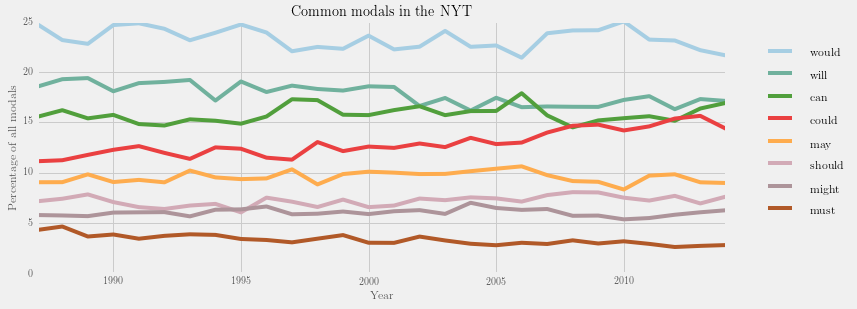

In [153]:
# line chart
plotter('Common modals in the NYT', rel_modals.results.drop('1963'), y_label = 'Percentage of all modals', 
        style = 'fivethirtyeight', num_to_plot = 8, legend_pos = 'outside upper right', figsize = (11, 5), save = True)

# pie chart
expl = [0 for s in list(each_modal_total.results)]
expl[-1] = 0.1
plotter('Pie chart of common modals in the NYT', each_modal_total.results, explode = expl,
        num_to_plot = 'all', kind = 'pie', colours = 'Accent', figsize = (11, 11), save = True)

# stacked area chart
plotter('An ocean of modals', rel_modals.results.drop('1963'), kind = 'area', stacked = True, colours = 'summer',
        figsize = (8, 10), num_to_plot = 'all', legend_pos = 'lower right', y_label = 'Percentage of all modals', save = True)

# bar chart, transposing and reversing the data
plotter('Modals use by decade', modals.results.iloc[::-1].T.iloc[::-1], kind = 'barh',
        x_label = 'Percentage of all modals', y_label = 'Modal group', save = True)

As you can see, there's a lot to do. These results all came from one very simple query! So, let's begin.

### The report

The focus of this notebook is our methodology and findings during our 2014 research project. These parts of the project are contextualised and elaborated upon in our written report. Depending on your browser's capabilities/settings, the following will download or display our report:

In [ ]:
from corpkit import report_display
report_display()

### The data

Our main corpus is comprised of paragraphs from *New York Times* articles that contain a risk word, which we have defined by regular expression as `'(?i)'.?\brisk.?\b'`. This includes *low-risk*, or *risk/reward* as single tokens, but excludes *brisk* or *asterisk*.

The data comes from a number of sources.

* 1963 editions were downloaded from ProQuest Newsstand as PDFs. Optical character recognition and manual processing was used to create a set of 1200 risk sentences.
* The 1987&ndash;2006 editions were taken from the *NYT Annotated Corpus*.
* 2007&ndash;2014 editions were downloaded from *ProQuest Newsstand* as HTML.

In total, 149,504 documents were processed. The corpus from which the risk corpus was made is over 150 million words in length!

The texts have been parsed for part of speech and grammatical structure by [`Stanford CoreNLP*](http://nlp.stanford.edu/software/corenlp.shtml). In this Notebook, we are only working with the parsed versions of the texts. We rely on [*Tregex*](http://nlp.stanford.edu/~manning/courses/ling289/Tregex.html) to interrogate the corpora. Tregex allows very complex searching of parsed trees, in combination with [Java Regular Expressions](http://docs.oracle.com/javase/7/docs/api/java/util/regex/Pattern.html). It's definitely worthwhile to learn the Tregex syntax, but in case you're time-poor, at the end of this notebook are a series of Tregex queries that you can copy and paste into `interrogator()` and `conc()` queries.

### Interrogating the corpus

So, let's start by finding out how many words we have in each subcorpus. To do this, we'll interrogate the corpus using `interrogator()`. Its most important arguments are:

1. **path to corpus**

2. Tregex **options**:
  * **'t/w/words'**: return only words
  * **'c/count'**: return a count of matches
  * **'p/pos'**: return only the tag
  * **'b/both'**: return tag and word together

3. a **Tregex query**

We only need to count tokens, so we can use the `'count'` option (it's often faster than getting lists of matching tokens). The cell below will run `interrogator()` over each annual subcorpus and count the number of matches for the query.

Some common Tregex patterns have been predefined. Searching for `'any'` will find any word in the corpus and count it.

In [5]:
allwords = interrogator(annual_trees, 'count', 'any') 

When the interrogation has finished, we can view our results:

In [6]:
# from the allwords results, print the totals
print allwords.totals

1963     83325
1987    481830
1988    450872
1989    473741
1990    443712
1991    397694
1992    402754
1993    412920
...
2007     906510
2008     992004
2009     944752
2010    1011854
2011    1090474
2012     995546
2013     978308
2014     623268
Name: Total, Length: 29, dtype: int64


If you want to see the query and options that created the results, you can use:

In [7]:
print allwords.query

['data/nyt/years', '/.?[A-Za-z0-9].?/ !< __', 'C']


### Plotting results

Lists of years and totals are pretty dry. Luckily, we can use the `plotter()` function to visualise our results. At minimum, `plotter()` needs two arguments:

1. a title (in quotation marks)
2. a list of results to plot

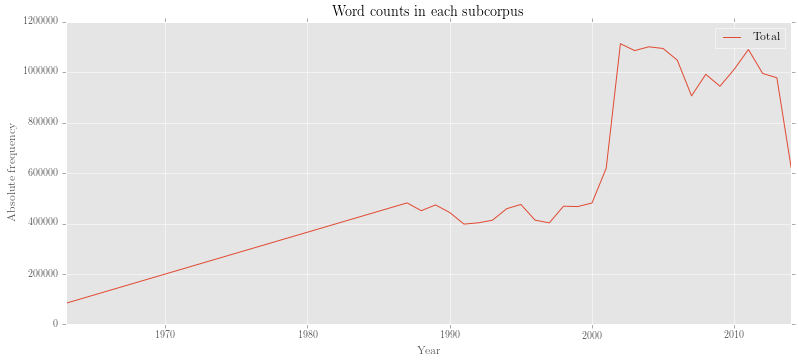

In [559]:
plotter('Word counts in each subcorpus', allwords.totals)

Because we have smaller samples for 1963 and 2014, we might want to project them. To do that, we can pass subcorpus names and projection values to `editor()`:


***Processing results***

Projection: 1963 * 5
Projection: 2014 * 1.37


***Done!***



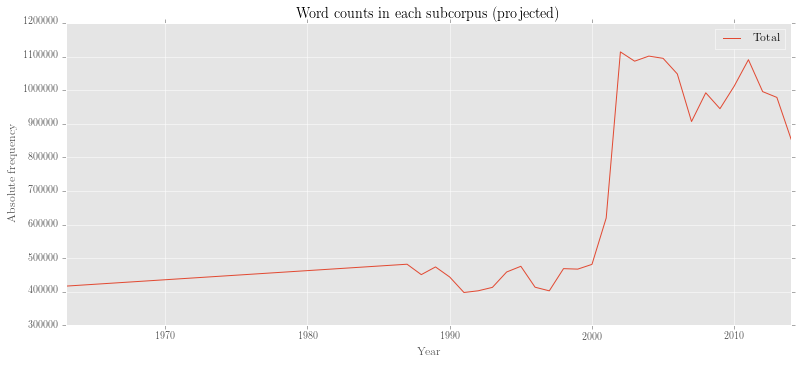

In [560]:
proj_vals = [(1963, 5), (2014, 1.37)]
projected = editor(allwords.totals, projection = proj_vals)
plotter('Word counts in each subcorpus (projected)', projected.totals)

Great! So, we can see that the number of words per year varies quite a lot, even after projection. That's worth keeping in mind.

### Frequency of risk words in the NYT

Next, let's count the total number of risk words. Notice that we are using the `'both'` flag, instead of the `'count'` flag, because we want both the word and its tag.

In [ ]:
# our query:
riskwords_query = r'__ < /(?i).?\brisk.?\b/' # any risk word and its word class/part of speech
# get all risk words and their tags :
riskwords = interrogator(annual_trees, 'both', riskwords_query)

Even when do not use the `count` flag, we can access the total number of matches as before:

In [356]:
riskwords.totals

1963    1476
1987    7511
1988    7226
...
2012    18606
2013    18454
2014    11406
Name: Total, Length: 29, dtype: int64

At the moment, it's hard to tell whether or not these counts are simply because our annual NYT samples are different sizes. To account for this, we can calculate the percentage of parsed words that are risk words. This means combining the two interrogations we have already performed.

We can do this by using `editor()`:

In [357]:
rel_riskwords = editor(riskwords.totals, '%', allwords.totals)


***Processing results***

***Done!***



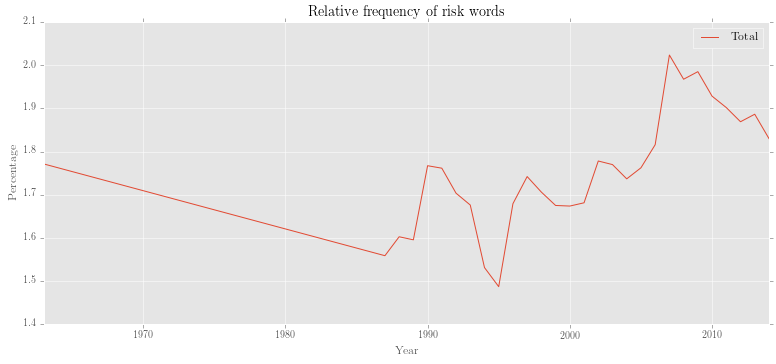

In [492]:
plotter('Relative frequency of risk words', rel_riskwords.totals)

That's more helpful. We can now see some interesting peaks and troughs in the proportion of risk words. We can also see that 1963 contains the highest proportion of risk words. This is because the manual corrector of 1963 OCR entries preserved only the sentence containing risk words, rather than the paragraph.

Here are two methods for excluding 1963 from the chart:

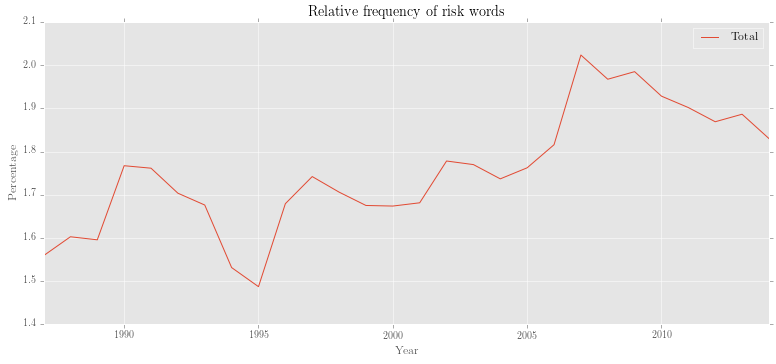

In [493]:
# using Pandas syntax:
plotter('Relative frequency of risk words', rel_riskwords.totals.drop('1963'))

# the other way: using editor()
#rel_riskwords = editor(rel_riskwords.totals, skip_subcorpora = [1963])
#plotter('Relative frequency of risk words', rel_riskwords.totals)

Perhaps we're interested in not only the frequency of risk words, but the frequency of different *kinds* of risk words. We actually already collected this data during our last `interrogator()` query.

We can print just the first few entries of the results list, rather than the totals list.

In [64]:
# using Pandas syntax:
riskwords.results.head(10)

(nn risk)  (nns risks)  (jj risky)  (vb risk)  (jj high-risk)      ...        (jj risk-allergic)  (nn risk-evaluation)  (nn risk-gd)  (nn risk-hedging)  (cd 410-risk)
1963   740        404          65         142          2                 ...        0                   0                     1             0                  1            
1987  4116       1612         549         493        265                 ...        0                   0                     0             0                  0            
1988  4049       1453         511         450        251                 ...        0                   0                     0             1                  0            
1989  4164       1534         543         512        283                 ...        0                   0                     0             0                  0            
1990  4223       1508         612         530        347                 ...        0                   0                     0             0                  0            
1991  3825       1372         530         483        282                 ...        1                   0                     0             0                  0            
1992  3578       1533         545         492        201                 ...        0                   0                     0             0                  0            
1993  3822       1426         546         444        209                 ...        0                   0                     0             0                  0            
1994  3837       1507         604         447        158                 ...        0                   0                     0             0                  0            
1995  3905       1429         632         400        178                 ...        0                   0                     0             0                  0            

[10 rows x 565 columns]

In [65]:
# using quickview
from corpkit import quickview
quickview(riskwords.results, n = 10)

  0: (nn risk) (n=204305)
  1: (nns risks) (n=76105)
  2: (jj risky) (n=22134)
  3: (vb risk) (n=19621)
  4: (jj high-risk) (n=7951)
  5: (vbp risk) (n=4294)
  6: (vbz risks) (n=3414)
  7: (nn risk-taking) (n=2204)
  8: (nnp risk) (n=1843)
  9: (jj low-risk) (n=1657)


So, let's use this data to do some more serious plotting:

In [359]:
frac1 = editor(riskwords.results, '%', riskwords.totals)
# alternative syntax:
# frac1 = editor(riskwords.results, '%', 'self')


***Processing results***

***Done!***



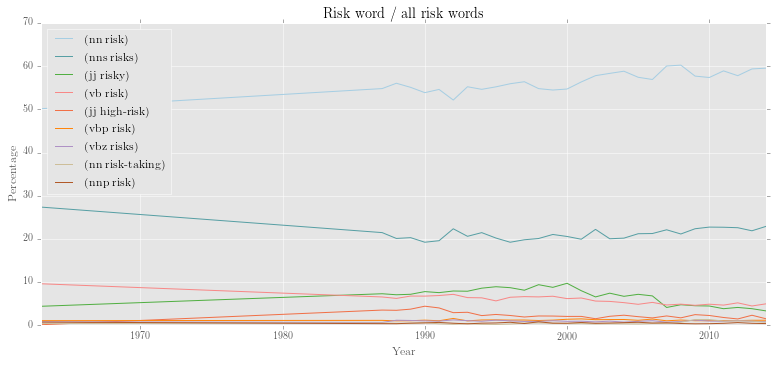

In [360]:
# colormap is used for > 7 results
plotter('Risk word / all risk words', frac1.results, num_to_plot = 9)

If `plotter()` can't find a good spot for the legend, you can explicitly move it:

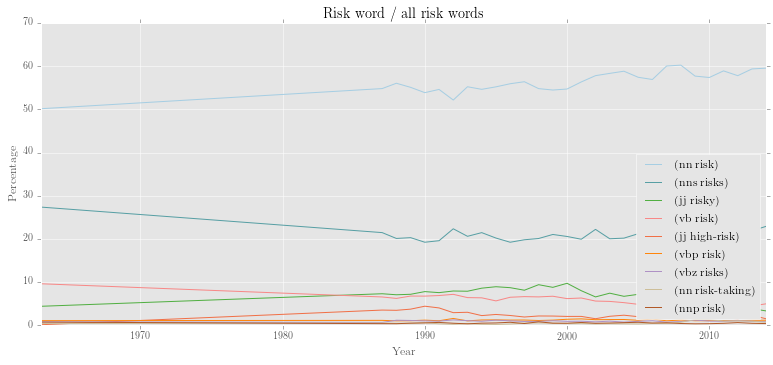

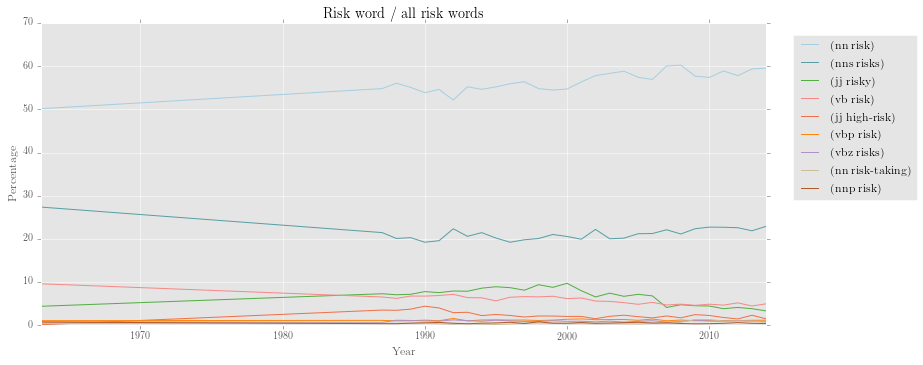

In [361]:
plotter('Risk word / all risk words', frac1.results, num_to_plot = 9, legend = 'lower right')
plotter('Risk word / all risk words', frac1.results, num_to_plot = 9, legend = 'outside right') # 'o r' for short

In [362]:
frac2 = editor(riskwords.results, '%', allwords.totals)


***Processing results***

***Done!***



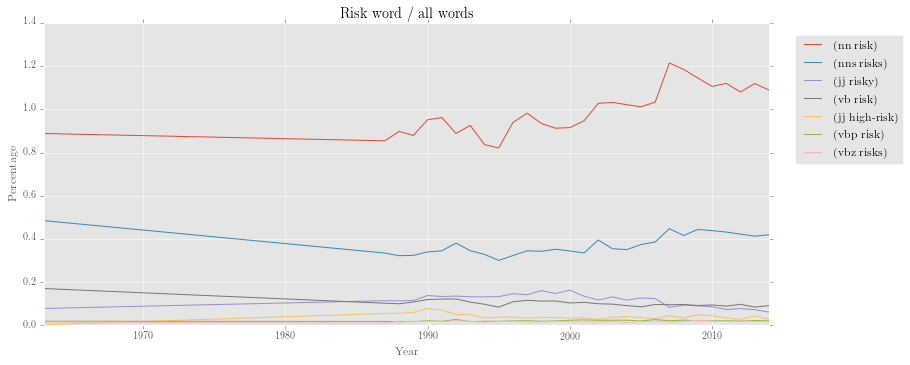

In [363]:
plotter('Risk word / all words', frac2.results, legend = 'outside right')

Another neat feature is the `.table` attribute of interrogations, which shows the most common `n` results in each subcorpus:

In [70]:
riskwords.table

1963         1987                  1988                  1989                 1990                          ...          2010                  2011                  2012                2013             2014                 
0     (nn risk)             (nn risk)             (nn risk)            (nn risk)            (nn risk)          ...                      (nn risk)             (nn risk)           (nn risk)        (nn risk)             (nn risk)
1   (nns risks)           (nns risks)           (nns risks)          (nns risks)          (nns risks)          ...                    (nns risks)           (nns risks)         (nns risks)      (nns risks)           (nns risks)
2     (vb risk)            (jj risky)            (jj risky)           (jj risky)           (jj risky)          ...                      (vb risk)             (vb risk)           (vb risk)        (vb risk)             (vb risk)
3    (jj risky)             (vb risk)             (vb risk)            (vb risk)            (vb risk)          ...                     (jj risky)            (jj risky)          (jj risky)       (jj risky)            (jj risky)
4    (vbp risk)        (jj high-risk)        (jj high-risk)       (jj high-risk)       (jj high-risk)          ...                 (jj high-risk)        (jj high-risk)      (jj high-risk)   (jj high-risk)        (jj high-risk)
..          ...                   ...                   ...                  ...                  ...          ...                            ...                   ...                 ...              ...                   ...
45                       (nnps risks)      (nn risk-taker.)    (nn risk-sharing)   (nn assigned-risk)          ...               (jj risk-return)      (jj risk-hungry)  (jj value-at-risk)    (nnp at-risk)  (jj risk-increasing)
46               (nn risk-assessment)     (jj risk-control)     (jj risk-factor)        (jj non-risk)          ...             (jj risk-advisory)     (nns risk-models)    (jj market-risk)     (vb de-risk)  (nn risk-prediction)
47                  (jj risk-adverse)     (nn risk-hedging)     (jj risk-waiver)   (jj variable-risk)          ...             (jj risk-tolerant)        (nnp low-risk)    (jj lowest-risk)   (jj risk-wary)     (nn risk/benefit)
48               (nn risk-management)       (nn less-risky)  (nn risk-to-reward)   (nn risk-aversion)          ...           (nn risk-to-benefit)  (jj risk-to-capital)       (nnp at-risk)     (jj risk-on)     (jj risk-damping)
49                (nn political-risk)  (jj risk-adjustment)    (jj risk-adverse)  (jj reward-to-risk)          ...             (jj very-low-risk)    (jj risk-tolerant)   (jj average-risk)  (jj risk-style)        (jj zero-risk)

[50 rows x 29 columns]

### Customising visualisations

By default, `plotter()` plots the seven most frequent results, including 1963.

 We can use other `plotter()` arguments to customise what our chart shows. `plotter()`'s possible arguments are:

 | `plotter()` argument | Mandatory/default?       |  Use          | Type  |
 | :------|:------- |:-------------|:-----|
 | `title` | **mandatory**      | A title for your plot | string |
 | `results` | **mandatory**      | the results you want to plot | `interrogator()` or `editor()` output |
 | `num_to_plot` | 7    | Number of top entries to show     |  int |
 | `x_label` | False    | custom label for the x-axis     |  str |
 | `y_label` | False    | custom label for the y-axis     |  str |
 | figsize | (13, 6) | set the size of the figure | tuple: `(length, width)`|
 | tex | `'try'` | use TeX to generate image text | boolean |
 | style | `'ggplot'` | use Matplotlib styles | str: `'dark_background'`, `'bmh'`, `'grayscale'`, `'ggplot'`, `'fivethirtyeight'`, `'matplotlib'` |
 | legend | `'default'` | legend position | str: `'outside right'` to move legend outside chart |

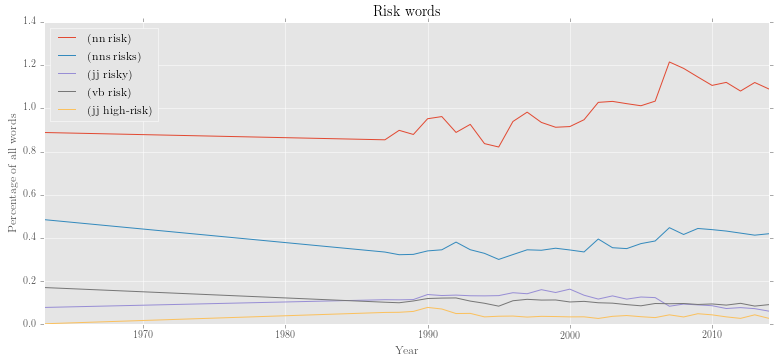

In [364]:
plotter('Risk words', frac2.results, num_to_plot = 5, y_label = 'Percentage of all words')

Keyword arguments for Pandas and matplotlib can also be used:

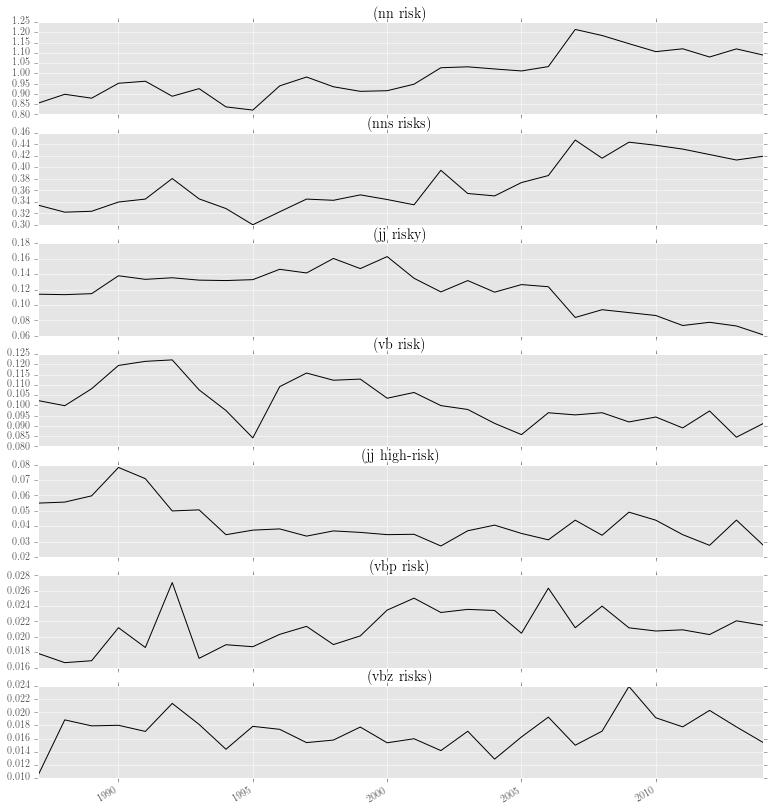

In [562]:
plotter('Risk words', frac2.results.drop('1963'), subplots = True)

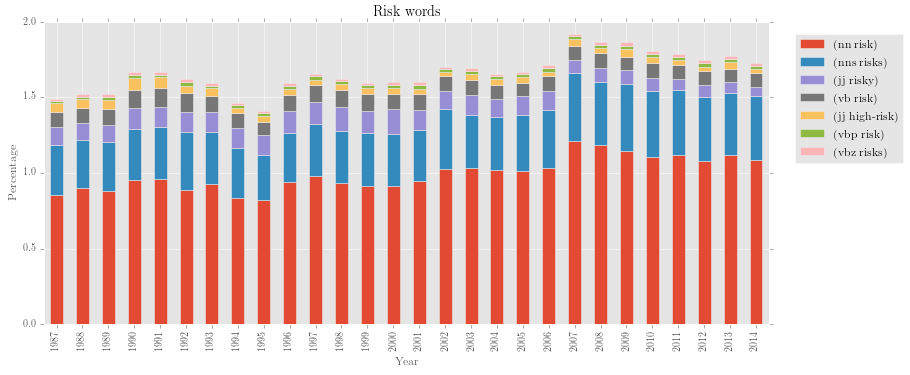

In [563]:
plotter('Risk words', frac2.results.drop('1963'), kind = 'bar', stacked = True, legend = 'o r')


***Processing results***

Keeping 15 entries:
    (vb risk)
    (vbp risk)
    (vbz risks)
    (vb de-risk)
    (vbg risk-taking)
    (vbz de-risks)
    (vbd risk-minded)
    (vb risk-manage)
    (vb at-risk)
    (vbd risks-be-damned)
... and 5 more ... 


***Done!***



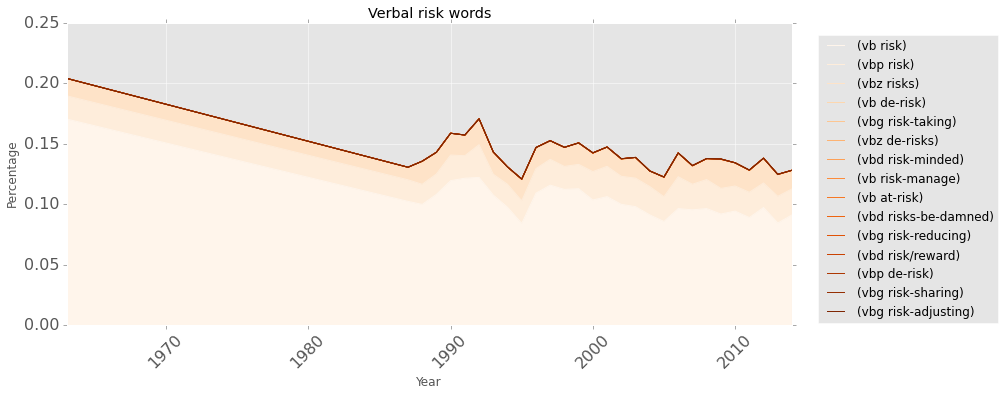

In [633]:
plotter('Verbal risk words', editor(frac2.results, just_entries= r'^\(v').results, kind = 'area', 
        stacked = True, legend = 'o r', colours = 'Oranges', num_to_plot = 'all', fontsize = 16, tex = False)

Those already proficient with Python can use Pandas' `plot()` function [(docs)](http://pandas.pydata.org/pandas-docs/stable/visualization.html) if they like.

Another neat thing you can do is save the results of an interrogation, so they don't have to be run the next time you load this notebook:

In [73]:
# specify what to save, and a name for the file.
from corpkit import save_result, load_result
save_result(allwords, 'allwords')

You can then load these results:

In [74]:
fromfile_allwords = load_result('allwords')
fromfile_allwords.totals

1963     83325
1987    481830
1988    450872
...
2012    995546
2013    978308
2014    623268
Name: Total, Length: 29, dtype: int64

... or erase them from memory:

In [75]:
fromfile_allwords = None
fromfile_allwords

### `quickview()`

`quickview()` is a function that quickly shows the n most frequent items in a list. Its arguments are:

1. `interrogator()` or `editor()` output (preferably, the whole interrogation, not just the `.results` branch.)
2. number of results to show (default = 25)

In [76]:
quickview(riskwords, n = 15)

  0: (nn risk) (n=204305)
  1: (nns risks) (n=76105)
  2: (jj risky) (n=22134)
  3: (vb risk) (n=19621)
  4: (jj high-risk) (n=7951)
  5: (vbp risk) (n=4294)
  6: (vbz risks) (n=3414)
  7: (nn risk-taking) (n=2204)
  8: (nnp risk) (n=1843)
  9: (jj low-risk) (n=1657)
 10: (jj at-risk) (n=1498)
 11: (jj risk-free) (n=1347)
 12: (jj risk-averse) (n=1258)
 13: (jj risk-taking) (n=1242)
 14: (nnp risky) (n=1198)


The number shown next to the item is its index. You can use this number to refer to an entry when editing results.

### `editor()`

Results lists can be edited quickly with `editor()`. It has a lot of different options:

 | `editor()` argument | Mandatory/default?       |  Use          | Type  |
 | :------|:------- |:-------------|:-----|
 | `df` | **mandatory**      | the results you want to edit | `interrogator()` or `editor` output |
 | `operation` | '%'      | if using second list, what operation to perform | `'+', '-', '/', '*' or '%'` |
 | `df2` | False      | Results to comine in some way with `df` | `interrogator()` or `editor` output (usually, a `.totals` branch) |
 | `just_subcorpora` | False    |   Subcorpora to keep   |  list |
 | `skip_subcorpora` | False    |   Subcorpora to skip   |  list |
 | `merge_subcorpora` | False    |   Subcorpora to merge   |  list |
 | `new_subcorpus_name` | False    |   name for merged subcorpora   |  index/str |
 | `just_entries` | False    |   Entries to keep   |  list |
 | `skip_entries` | False    |   Entries to skip   |  list |
 | `merge_entries` | False    |   Entries to merge   |  list of words or indices/a regex to match |
 | `sort_by` | False    |   sort results   |  str: `'total', 'infreq', 'name', 'increase', 'decrease'` |
 | `keep_top` | False    |   Keep only top n results after sorting   |  int |
 | `just_totals` | False    |   Collapse all subcorpora, return Series   | bool |
 | `projection` | False    |   project smaller subcorpora   |  list of tuples: [`(subcorpus_name, projection_value)]` |
 | `**kwargs` | False    |   pass options to *Pandas*' `plot()` function, *Matplotlib*   |  various |

First, we can select specific subcorpora to keep, remove or span:

Let's try these out on a new interrogation. The query below will get adjectival risk words:

In [58]:
adj = r'/JJ.?/ < /(?i)\brisk/'
adj_riskwords = interrogator(annual_trees, 'words', adj)

 16:26:20: Finished! 355 unique results, 45604 total.


In [60]:
editor(adj_riskwords.results, skip_subcorpora = [1963, 1987, 1988]).results


***Processing results***

Skipping 3 subcorpora:
    1963
    1987
    1988


***Done!***



risky  high-risk  riskier  low-risk  at-risk           ...             ultra-low-risk  medical-risk  ultra-high-risk  middle-risk  risk-and-profit-sharing
1989  543    283         65       35        10               ...             0               0             0                0            0                      
1990  612    347         84       40        19               ...             0               0             0                0            0                      
1991  530    282         81       46        17               ...             1               0             0                0            0                      
1992  545    201         53       28        13               ...             0               1             1                0            0                      
1993  546    209         78       42        16               ...             0               0             0                0            0                      
1994  604    158         62       23        24               ...             0               0             0                0            0                      
1995  632    178         68       44        15               ...             0               0             0                0            0                      
1996  605    158         66       31        26               ...             0               0             0                0            1                      
...     ...        ...      ...       ...      ...           ...                        ...           ...              ...          ...                      ...
2007  758    398        140       60        82               ...             0               0             0                0            0                      
2008  930    338        176       82        86               ...             0               0             0                0            0                      
2009  850    464        200       82       118               ...             0               0             0                0            0                      
2010  872    444        194       90       102               ...             0               0             0                0            0                      
2011  798    376        162      110       106               ...             0               0             0                0            0                      
2012  770    274        172      154       118               ...             0               0             0                0            0                      
2013  710    430        148      106       132               ...             0               0             0                0            0                      
2014  380    172         86       84        78               ...             0               0             0                0            0                      

[26 rows x 355 columns]

In [61]:
editor(adj_riskwords.results, just_subcorpora = [1963, 1987, 1988]).results


***Processing results***

Keeping 3 subcorpora:
    1963
    1987
    1988


***Done!***



risky  high-risk  riskier  low-risk  at-risk           ...             ultra-low-risk  medical-risk  ultra-high-risk  middle-risk  risk-and-profit-sharing
1963   65      2         3        1         0                ...             0               0             0                0            0                      
1987  549    265        49       43        12                ...             0               0             0                0            0                      
1988  511    251        44       38        27                ...             0               0             0                0            0                      

[3 rows x 355 columns]

In [62]:
editor(adj_riskwords.results, span_subcorpora = [2000, 2010]).results


***Processing results***

Keeping subcorpora:
    2000--2010


***Done!***



risky  high-risk  riskier  low-risk  at-risk           ...             ultra-low-risk  medical-risk  ultra-high-risk  middle-risk  risk-and-profit-sharing
2000   784   166         75      25         42               ...             0               0             0                0            0                      
2001   834   215         98      50         33               ...             0               0             0                0            0                      
2002  1302   302        174      68         44               ...             0               0             0                0            0                      
2003  1430   402        190      54         58               ...             0               0             0                0            0                      
2004  1284   448        186      72         68               ...             0               0             0                0            0                      
2005  1384   386        190      82         84               ...             0               0             0                0            0                      
2006  1296   326        184      80         96               ...             0               0             0                0            0                      
2007   758   398        140      60         82               ...             0               0             0                0            0                      
2008   930   338        176      82         86               ...             0               0             0                0            0                      
2009   850   464        200      82        118               ...             0               0             0                0            0                      
2010   872   444        194      90        102               ...             0               0             0                0            0                      

[11 rows x 355 columns]

We can do similar kinds of things with each *result*:

In [63]:
quickview(adj_riskwords.results)

  0: risky (n=22134)
  1: high-risk (n=7951)
  2: riskier (n=3221)
  3: low-risk (n=1657)
  4: at-risk (n=1498)
  5: risk-free (n=1347)
  6: risk-averse (n=1258)
  7: risk-taking (n=1242)
  8: riskiest (n=995)
  9: risk-based (n=361)
 10: higher-risk (n=337)
 11: risk-management (n=324)
 12: risk-adjusted (n=256)
 13: risk-reward (n=240)
 14: risk-weighted (n=186)
 15: risk-benefit (n=151)
 16: no-risk (n=151)
 17: lower-risk (n=148)
 18: highest-risk (n=148)
 19: riskless (n=128)
 20: moderate-risk (n=58)
 21: assigned-risk (n=54)
 22: risk-off (n=52)
 23: risk-sharing (n=49)
 24: reduced-risk (n=47)


In [65]:
editor(adj_riskwords.results, skip_entries = [2, 5, 6]).results


***Processing results***

Skipping 3 entries:
    riskier
    risk-free
    risk-averse


***Done!***



risky  high-risk  low-risk  at-risk  risk-taking           ...             ultra-low-risk  medical-risk  ultra-high-risk  middle-risk  risk-and-profit-sharing
1963   65      2          1         0       1                    ...             0               0             0                0            0                      
1987  549    265         43        12      21                    ...             0               0             0                0            0                      
1988  511    251         38        27      19                    ...             0               0             0                0            0                      
1989  543    283         35        10      28                    ...             0               0             0                0            0                      
1990  612    347         40        19      21                    ...             0               0             0                0            0                      
1991  530    282         46        17      24                    ...             1               0             0                0            0                      
1992  545    201         28        13      22                    ...             0               1             1                0            0                      
1993  546    209         42        16      22                    ...             0               0             0                0            0                      
...     ...        ...       ...      ...          ...           ...                        ...           ...              ...          ...                      ...
2007  758    398         60        82      80                    ...             0               0             0                0            0                      
2008  930    338         82        86      92                    ...             0               0             0                0            0                      
2009  850    464         82       118      76                    ...             0               0             0                0            0                      
2010  872    444         90       102      74                    ...             0               0             0                0            0                      
2011  798    376        110       106      68                    ...             0               0             0                0            0                      
2012  770    274        154       118      78                    ...             0               0             0                0            0                      
2013  710    430        106       132      82                    ...             0               0             0                0            0                      
2014  380    172         84        78      36                    ...             0               0             0                0            0                      

[29 rows x 352 columns]

In [66]:
editor(adj_riskwords.results, just_entries = [2, 5, 6]).results


***Processing results***

Keeping 3 entries:
    riskier
    risk-free
    risk-averse


***Done!***



riskier  risk-free  risk-averse
1963    3        3          0        
1987   49       29         10        
1988   44       31         11        
1989   65       21          8        
1990   84       23          9        
1991   81       22          9        
1992   53       23          9        
1993   78       32         15        
...       ...        ...          ...
2007  140       44        100        
2008  176       52         92        
2009  200       84         96        
2010  194      112         72        
2011  162      134         90        
2012  172       56         90        
2013  148       58         70        
2014   86       42         36        

[29 rows x 3 columns]

We can also use the words themselves, rather than indices, for all of these operations:

In [381]:
editor(adj_riskwords.results, just_entries = ['risky', 'riskier', 'riskiest']).results


***Processing results***

Keeping 2 entries:
    (nn risk-management)
    (jj risk-management)

***Done!***



(jj risk-management)  (nn risk-management)
1963   0                     0                  
1987   2                     1                  
1988   1                     0                  
1989   3                     5                  
1990   5                     1                  
...                    ...                   ...
2010  14                    16                  
2011   4                     4                  
2012  28                     6                  
2013  20                     0                  
2014  20                     6                  

[29 rows x 2 columns]

Or, we can use Regular Expressions:

In [68]:
# skip any that start with 'r'
editor(adj_riskwords.results, skip_entries = r'^r').results


***Processing results***

Skipping 176 entries:
    risky
    riskier
    risk-free
    risk-averse
    risk-taking
    riskiest
    risk-based
    risk-management
    risk-adjusted
    risk-reward
... and 166 more ... 


***Done!***



high-risk  low-risk  at-risk  higher-risk  no-risk     ...       low-risk/low-return  ultra-low-risk  medical-risk  ultra-high-risk  middle-risk
1963    2          1         0       1           5           ...       0                    0               0             0                0          
1987  265         43        12       4           3           ...       0                    0               0             0                0          
1988  251         38        27       8           6           ...       0                    0               0             0                0          
1989  283         35        10       8           4           ...       0                    0               0             0                0          
1990  347         40        19       8           4           ...       0                    0               0             0                0          
1991  282         46        17      15           2           ...       1                    1               0             0                0          
1992  201         28        13       9           5           ...       0                    0               1             1                0          
1993  209         42        16      15           4           ...       0                    0               0             0                0          
...         ...       ...      ...          ...      ...     ...                       ...             ...           ...              ...          ...
2007  398         60        82      28           4           ...       0                    0               0             0                0          
2008  338         82        86       4           4           ...       0                    0               0             0                0          
2009  464         82       118      16           4           ...       0                    0               0             0                0          
2010  444         90       102      22           6           ...       0                    0               0             0                0          
2011  376        110       106      22           2           ...       0                    0               0             0                0          
2012  274        154       118      26           2           ...       0                    0               0             0                0          
2013  430        106       132      26           8           ...       0                    0               0             0                0          
2014  172         84        78      14           2           ...       0                    0               0             0                0          

[29 rows x 179 columns]

We can also merge entries, and specify a new name for the merged items. In lieu of a name, we can pass an index. 

In [69]:
editor(adj_riskwords.results, merge_entries = [2, 5, 6], newname = 'New name').results


***Processing results***

Merging 3 entries as "New name":
    riskier
    risk-free
    risk-averse


***Done!***



risky  high-risk  low-risk  at-risk  risk-taking    ...     medical-risk  ultra-high-risk  middle-risk  risk-and-profit-sharing  New name
1963   65      2          1         0       1             ...     0             0                0            0                          6     
1987  549    265         43        12      21             ...     0             0                0            0                         88     
1988  511    251         38        27      19             ...     0             0                0            0                         86     
1989  543    283         35        10      28             ...     0             0                0            0                         94     
1990  612    347         40        19      21             ...     0             0                0            0                        116     
1991  530    282         46        17      24             ...     0             0                0            0                        112     
1992  545    201         28        13      22             ...     1             1                0            0                         85     
1993  546    209         42        16      22             ...     0             0                0            0                        125     
...     ...        ...       ...      ...          ...    ...              ...              ...          ...                      ...       ...
2007  758    398         60        82      80             ...     0             0                0            0                        284     
2008  930    338         82        86      92             ...     0             0                0            0                        320     
2009  850    464         82       118      76             ...     0             0                0            0                        380     
2010  872    444         90       102      74             ...     0             0                0            0                        378     
2011  798    376        110       106      68             ...     0             0                0            0                        386     
2012  770    274        154       118      78             ...     0             0                0            0                        318     
2013  710    430        106       132      82             ...     0             0                0            0                        276     
2014  380    172         84        78      36             ...     0             0                0            0                        164     

[29 rows x 353 columns]

In [72]:
editor(adj_riskwords.results, merge_entries = ['risky', 'riskier', 'riskiest'], newname = 'risky').results


***Processing results***

Merging 3 entries as "risky":
    risky
    riskier
    riskiest


***Done!***



Notice how the merged result appears as the final column. To reorder the columns by total frequency, we can use `sort_by = 'total'`.

In [74]:

# if we don't specify a new name, editor makes one for us
generated_name = editor(adj_riskwords.results, merge_entries = ['risky', 'riskier', 'riskiest'], sort_by = 'total')
quickview(generated_name.results)


***Processing results***

Merging 3 entries as "risky/riskier/riskiest":
    risky
    riskier
    riskiest


***Done!***

  0: risky/riskier/riskiest (n=26350)
  1: high-risk (n=7951)
  2: low-risk (n=1657)
  3: at-risk (n=1498)
  4: risk-free (n=1347)
  5: risk-averse (n=1258)
  6: risk-taking (n=1242)
  7: risk-based (n=361)
  8: higher-risk (n=337)
  9: risk-management (n=324)
 10: risk-adjusted (n=256)
 11: risk-reward (n=240)
 12: risk-weighted (n=186)
 13: risk-benefit (n=151)
 14: no-risk (n=151)
 15: lower-risk (n=148)
 16: highest-risk (n=148)
 17: riskless (n=128)
 18: moderate-risk (n=58)
 19: assigned-risk (n=54)
 20: risk-off (n=52)
 21: risk-sharing (n=49)
 22: reduced-risk (n=47)
 23: lowest-risk (n=45)
 24: risk-control (n=42)


`editor()` can sort also sort alphabetically, or by least frequent:

In [75]:
# alphabetically
editor(adj_riskwords.results, sort_by = 'name').results


***Processing results***


***Done!***



acceptable-risk  advanced-risk  aids-risk  all-risk  all-risking    ...      war-risk  weather-risk  youth-at-risk  zero-political-risk  zero-risk
1963  0                0              0          0         0              ...      0         0             0              0                    0        
1987  0                0              0          2         0              ...      0         0             0              0                    0        
1988  0                0              0          0         1              ...      2         0             0              0                    1        
1989  0                0              0          1         1              ...      0         0             0              0                    1        
1990  0                0              1          0         0              ...      6         0             0              0                    0        
1991  0                0              0          0         1              ...      6         0             0              0                    0        
1992  0                0              0          0         0              ...      0         0             0              0                    0        
1993  0                0              0          0         0              ...      0         0             0              0                    1        
...               ...            ...        ...       ...          ...    ...           ...           ...            ...                  ...        ...
2007  0                0              0          2         0              ...      2         0             0              0                    0        
2008  0                0              0          0         0              ...      0         0             0              0                    0        
2009  0                0              0          0         0              ...      0         0             0              0                    2        
2010  0                0              0          0         0              ...      0         0             0              0                    2        
2011  0                0              0          0         0              ...      0         0             0              0                    2        
2012  0                0              0          0         0              ...      0         0             0              0                    2        
2013  0                0              0          0         0              ...      0         0             0              0                    0        
2014  0                0              0          0         0              ...      0         0             0              0                    2        

[29 rows x 355 columns]

In [76]:
# least frequent
editor(adj_riskwords.results, sort_by = 'infreq').results


***Processing results***


***Done!***



middle-risk  risk-waiver  risk-swapping  crime-risk  risk-study  ...    at-risk  low-risk  riskier  high-risk  risky
1963  0            0            0              0           0           ...      0        1         3        2         65  
1987  0            0            0              0           0           ...     12       43        49      265        549  
1988  0            0            0              0           0           ...     27       38        44      251        511  
1989  0            1            0              0           0           ...     10       35        65      283        543  
1990  0            0            0              0           0           ...     19       40        84      347        612  
1991  0            0            0              0           0           ...     17       46        81      282        530  
1992  0            0            0              0           0           ...     13       28        53      201        545  
1993  0            0            0              0           0           ...     16       42        78      209        546  
...           ...          ...            ...         ...         ...  ...        ...       ...      ...        ...    ...
2007  0            0            0              0           0           ...     82       60       140      398        758  
2008  0            0            0              0           0           ...     86       82       176      338        930  
2009  0            0            0              0           0           ...    118       82       200      464        850  
2010  0            0            0              0           0           ...    102       90       194      444        872  
2011  0            0            0              0           0           ...    106      110       162      376        798  
2012  0            0            0              0           0           ...    118      154       172      274        770  
2013  0            0            0              0           0           ...    132      106       148      430        710  
2014  0            0            0              0           0           ...     78       84        86      172        380  

[29 rows x 355 columns]

Particularly cool is sorting by 'increase' or 'decrease': this calculates the trend lines of each result, and sort by the slope.

In [77]:
editor(adj_riskwords.results, sort_by = 'increase').results


***Processing results***


***Done!***



risky  high-risk  riskier  at-risk  risk-averse      ...        event-risk  risk-arbitrage  standard-risk  riskless  assigned-risk
1963   65      2          3        0        0              ...        0           0               7               3         0           
1987  549    265         49       12       10              ...        0           4               0               9         0           
1988  511    251         44       27       11              ...        0           1               0              12         7           
1989  543    283         65       10        8              ...        9           2               0               6         7           
1990  612    347         84       19        9              ...        5           3               0               8        13           
1991  530    282         81       17        9              ...        0           1               0               4         4           
1992  545    201         53       13        9              ...        0           0               0               4         5           
1993  546    209         78       16       15              ...        0           0               0               5         2           
...     ...        ...      ...      ...          ...      ...               ...             ...            ...       ...            ...
2007  758    398        140       82      100              ...        0           0               0               8         0           
2008  930    338        176       86       92              ...        0           0               0               2         0           
2009  850    464        200      118       96              ...        0           0               0               4         0           
2010  872    444        194      102       72              ...        0           0               0               6         0           
2011  798    376        162      106       90              ...        2           0               0               2         0           
2012  770    274        172      118       90              ...        0           0               0               4         0           
2013  710    430        148      132       70              ...        0           0               0               2         0           
2014  380    172         86       78       36              ...        0           0               0               2         0           

[29 rows x 355 columns]

We can use `just_totals` to output just the sum of occurrences in each subcorpus:

In [78]:
editor(adj_riskwords.results, just_totals = True).results


***Processing results***


***Done!***



risky        22134
high-risk     7951
riskier       3221
low-risk      1657
at-risk       1498
risk-free     1347
...
risk-inviting              1
ultra-low-risk             1
medical-risk               1
ultra-high-risk            1
middle-risk                1
risk-and-profit-sharing    1
Name: Combined total, Length: 355, dtype: int64

A handy thing about working with Pandas DataFrames is that we can easily translate our results to other formats:

In [79]:
deceasing = editor(adj_riskwords.results, sort_by = 'decrease')


***Processing results***


***Done!***



In [80]:
# tranpose with T, get just top 5 results, print as CSV
print deceasing.results.T.head().to_csv()

,1963,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
assigned-risk,0.0,0.0,7.0,7.0,13.0,4.0,5.0,2.0,5.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
riskless,3.0,9.0,12.0,6.0,8.0,4.0,4.0,5.0,5.0,5.0,5.0,2.0,3.0,5.0,4.0,4.0,4.0,0.0,4.0,2.0,4.0,8.0,2.0,4.0,6.0,2.0,4.0,2.0,2.0
standard-risk,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
risk-arbitrage,0.0,4.0,1.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
event-risk,0.0,0.0,0.0,9.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0



In [81]:
# or, print to latex markup:
print deceasing.results.T.head().to_latex()

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
{} &  1963 &  1987 &  1988 &  1989 &  1990 &  1991 &  1992 &  1993 &  1994 &  1995 &  1996 &  1997 &  1998 &  1999 &  2000 &  2001 &  2002 &  2003 &  2004 &  2005 &  2006 &  2007 &  2008 &  2009 &  2010 &  2011 &  2012 &  2013 &  2014 \\
\midrule
assigned-risk  &  0    &  0    &   7   &  7    &  13   &  4    &  5    &  2    &  5    &  2    &  0    &  3    &  0    &  0    &  0    &  0    &  2    &  0    &  0    &  4    &  0    &  0    &  0    &  0    &  0    &  0    &  0    &  0    &  0    \\
riskless       &  3    &  9    &  12   &  6    &   8   &  4    &  4    &  5    &  5    &  5    &  5    &  2    &  3    &  5    &  4    &  4    &  4    &  0    &  4    &  2    &  4    &  8    &  2    &  4    &  6    &  2    &  4    &  2    &  2    \\
standard-risk  &  7    &  0    &   0   &  0    &   0   &  0    &  0    &  0    &  0    &  0    &  0    &  0    &  0    &  0    &  0    &  0    &  0    &  0    &  0    &  0    &  0    &  0    &  0 

Of course, you can perform many of these operations at the same time. Problems may arise, however, especially if your options contradict.

In [87]:
editor(adj_riskwords.results, '%', adj_riskwords.totals, span_subcorpora = [1990, 2000], 
    just_entries = r'^[^r]', merge_entries = r'er$', newname = 'risk-comparative?', sort_by = 'total').results


***Processing results***

Merging 6 entries as "risk-comparative?":
    riskier
    ever-riskier
    risk-transfer
    risker
    still-riskier
    risk-waiver

Keeping subcorpora:
    1990--2000

Keeping 177 entries:
    high-risk
    low-risk
    at-risk
    higher-risk
    no-risk
    lower-risk
    highest-risk
    moderate-risk
    assigned-risk
    lowest-risk
... and 167 more ... 


***Done!***



high-risk  low-risk  at-risk   higher-risk  no-risk      ...       modified-risk  mine-risk  medium-low-risk  low-risk-pass  carbon-risk
1990  26.795367  3.088803  1.467181  0.617761     0.308880     ...       0              0          0                0              0          
1991  24.479167  3.993056  1.475694  1.302083     0.173611     ...       0              0          0                0              0          
1992  19.881306  2.769535  1.285856  0.890208     0.494560     ...       0              0          0                0              0          
1993  19.496269  3.917910  1.492537  1.399254     0.373134     ...       0              0          0                0              0          
1994  15.076336  2.194656  2.290076  0.763359     1.145038     ...       0              0          0                0              0          
1995  16.036036  3.963964  1.351351  0.540541     0.450450     ...       0              0          0                0              0          
1996  14.602588  2.865065  2.402957  0.739372     0.646950     ...       0              0          0                0              0          
1997  13.540622  2.607823  3.209629  0.501505     0.702106     ...       0              0          0                0              0          
1998  14.030819  2.838605  1.216545  0.486618     0.324412     ...       0              0          0                0              0          
1999  14.383562  2.226027  2.140411  0.428082     0.428082     ...       0              0          0                0              0          
2000  13.301282  2.003205  3.365385  0.400641     0.080128     ...       0              0          0                0              0          

[11 rows x 177 columns]

### Diversity of risk words

It's important to note that the kind of results we generate are hackable. We could count the number of unique risk words in each subcorpus by changing any count over 1 to 1.

In [394]:
import numpy as np
# copy our list
uniques = riskwords.results.copy()
# divide every result by itself
for f in uniques:
    uniques[f] = uniques[f] / uniques[f]
# get rid of inf scores (i.e. 0 / 0) using numpy
uniques = uniques.replace(np.inf, 0)
# sum the results
u = uniques.T.sum()
# give our data a name
u.name = 'Unique risk words'

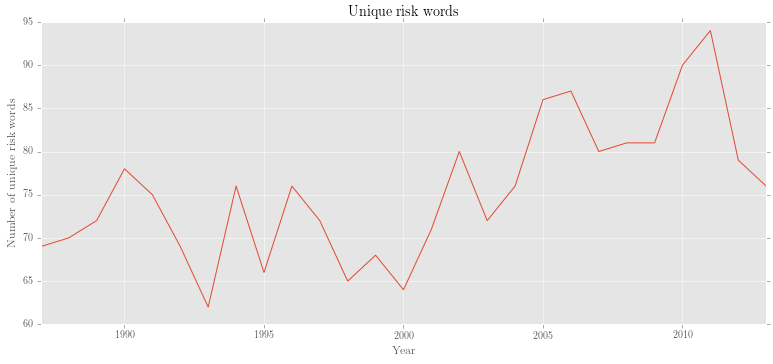

In [396]:
plotter('Unique risk words', u.drop(['1963', '2014']), y_label = 'Number of unique risk words', legend = False)

So, we can see a generally upward trajectory, with more risk words constantly being used. Many of these results appear once, however, and many are nonwords. *Can you figure out how to remove words that appear only once per year?*

### conc()

`conc()` produces concordances of a subcorpus based on a Tregex query. Its main arguments are:

1. A subcorpus to search *(remember to put it in quotation marks!)*
2. A Tregex query

In [132]:
# here, we use a subcorpus of politics articles,
# rather than the total annual editions.
adj_lines = conc('data/nyt/topics/politics/1999', r'/JJ.?/ << /(?i).?\brisk.?\b/') # adj containing a risk word


23:51:14: Getting concordances for data/nyt/topics/politics/1999 ... 
          Query: /JJ.?/ << /(?i).?\brisk.?\b/

0          , Mr. Wahid seems to be playing a       risky   game of free-rein leadership            
1     after making disastrous investments in       risky   securities , has a lower rating among   
2                         That was the least       risky   course but one that left the initiative 
3     A party-line vote on witnesses is more       risky   politically for Republicans than        
4     decision to fire General Musharraf was       risky   ; in Pakistan , generals have ruled for 
5                                   It was a       risky   strategy , but Mr. Lee apparently       
6                 As Indonesia undergoes its       risky   on-the-job training in democracy in the 
7     -- said creative legal arguments and a       risky   strategy of challenging some facts in   
8   electoral setbacks produced increasingly       risky   financial decisions by 

You can set `conc()` to print only the first ten examples with `n = 10`, or ten random these with the `n = 15, random = True` parameter.

In [99]:
lines = conc('data/nyt/years/2007', r'/VB.?/ < /(?i).?\brisk.?\b/', n = 15, random = True)


19:23:10: Getting concordances for data/nyt/years/2007 ... 
          Query: /VB.?/ < /(?i).?\brisk.?\b/

0     'll have to fight them alone and then    risk   having to live under the thumb of Iran  
1       's branch system was meant to shift    risk   away from the company to the federal    
2      beat four spades and did not want to    risk   taking a phantom sacrifice -- going down
3     rates and sweeten the repayment -- or    risk   having to withdraw the offerings        
4    and helplessness : residents refuse to    risk   their lives by helping a police force   
5   automakers get back on stable ground or    risk   further cutbacks at General Motors , the
6         When rooms are n't ready , hotels    risk   their reputations and make guests feel  
7        could be as they caved rather than    risk   drawing demagogic fire from the gun     
8          legitimacy even in cases when it   risks   the possibility of losing the prize     
9    Bank of Richmond , said in a spee

`conc()` takes another argument, window, which alters the amount of co-text appearing either side of the match. The default is 50 characters

In [100]:
lines = conc('data/nyt/topics/health/2013', r'/VB.?/ << /(?i).?\brisk.?\b/', n = 15, random = True, window = 20)


19:23:57: Getting concordances for data/nyt/topics/health/2013 ... 
          Query: /VB.?/ << /(?i).?\brisk.?\b/

0       like yours would            risk   damaging its        
1     should not have to            risk   their health        
2         , they can not            risk   having their        
3    care law intact and            risk   a conservative      
4       back years after   risk-reducing   surgery with uterine
5    prolonged pain , to            risk   grave injury and    
6    HealthCare.gov that            risk   the private         
7   what they want , you            risk   reigniting the      
8      warning that they            risk   scrambling hormones 
9         the rights and            risk   the well-being of   
10       what they do or            risk   having cost controls
11  they were willing to            risk   a shutdown over it  
12   legislators , would            risk   being thwarted yet  
13             This case           risks   doing so 

`conc()` also allows you to view parse trees. By default, it's false:

In [107]:
lines = conc('data/nyt/years/2013', r'/VB.?/ < /(?i)\btrad.?/', trees = True)


19:25:39: Getting concordances for data/nyt/years/2013 ... 
          Query: /VB.?/ < /(?i)\btrad.?/

0   ) (PP (IN as) (S (ADVP (RB simply)) (VP   (VBG trading)   (NP (NP (CD one) (NN risk)) (PP (IN for
1   curities)) (SBAR (S (NP (PRP they)) (VP     (VBP trade)   (CC and) (VBP hold))))))))))))) (. .)))
2   S (NP (PRP they)) (VP (VBD started) (NP   (VBG trading)   (NNS options))))))) (. .)))            
3   S (NP (DT a) (JJ German) (NN bank)) (VP    (VBN traded)   (PP (IN in) (NP (NP (NNP New) (NNP York
4   P (WDT which))) (S (NP (NNS banks)) (VP     (VBP trade)   (PP (IN for) (NP (PRP$ their) (JJ own) 
5   NP (NP (DT some) (NNS derivatives)) (VP   (VBG trading)   (PP (IN into) (NP (NP (JJ separate) (NN
6   (S (S (NP (PRP You)) (VP (MD might) (VP      (VB trade)   (NP (DT a) (JJ small)) (PP (CC plus) (P
7   were) (VP (ADVP (RBR more) (RB easily))    (VBN traded)   (PP (IN on) (NP (DT the) (JJ public) (N
8   ) (, ,) (VP (VBP say)))))) (, ,) (S (VP   (VBG trading)   (NP (NNS securities

Just like our other data, conc lines can be edited with `editor()`, or outputted as CSV.

In [108]:
lines = editor(lines, skip_entries = [1, 2, 4, 5])
print lines


***Processing results***

   l                                         m              r                                        
0   ) (PP (IN as) (S (ADVP (RB simply)) (VP   (VBG trading)   (NP (NP (CD one) (NN risk)) (PP (IN for
1   S (NP (DT a) (JJ German) (NN bank)) (VP    (VBN traded)   (PP (IN in) (NP (NP (NNP New) (NNP York
2   (S (S (NP (PRP You)) (VP (MD might) (VP      (VB trade)   (NP (DT a) (JJ small)) (PP (CC plus) (P
3   were) (VP (ADVP (RBR more) (RB easily))    (VBN traded)   (PP (IN on) (NP (DT the) (JJ public) (N
4   ) (, ,) (VP (VBP say)))))) (, ,) (S (VP   (VBG trading)   (NP (NNS securities)))) (, ,) (S (VP (T
..                                       ...            ...                                       ...
31   in) (NP (DT a) (NNS derivatives))) (VP   (VBG trading)   (NP (NN debacle)) (PP (IN in) (NP (NNP 
32  )) (VP (VBZ is) (ADVP (RB already)) (VP   (VBG trading)   (PP (IN at) (NP (JJ low) (NNS yields)))
33  s)) (NN willingness) (S (VP (TO to) (VP      (VB tr

If the concordance lines aren't print well, you can use `concprinter()`:

In [109]:
from corpkit import concprinter
concprinter(lines)


0   ) (PP (IN as) (S (ADVP (RB simply)) (VP   (VBG trading)   (NP (NP (CD one) (NN risk)) (PP (IN for
1   S (NP (DT a) (JJ German) (NN bank)) (VP    (VBN traded)   (PP (IN in) (NP (NP (NNP New) (NNP York
2   (S (S (NP (PRP You)) (VP (MD might) (VP      (VB trade)   (NP (DT a) (JJ small)) (PP (CC plus) (P
3   were) (VP (ADVP (RBR more) (RB easily))    (VBN traded)   (PP (IN on) (NP (DT the) (JJ public) (N
4   ) (, ,) (VP (VBP say)))))) (, ,) (S (VP   (VBG trading)   (NP (NNS securities)))) (, ,) (S (VP (T
5        (ROOT (S (NP (NNS Stocks)) (VP (VP    (VBD traded)   (ADJP (RB steadily) (JJR higher)) (PP (
6   )) (SBAR (IN as) (S (NP (PRP they)) (VP    (VBD traded)   (ADJP (JJR higher))))))))))) (, ,) (NP 
7   NP (JJR more) (NNS derivatives)) (S (VP   (VBG trading)   (PRT (IN out)) (PP (IN of) (NP (DT the)
8   NP (PRP We)) (VP (MD will) (RB not) (VP      (VB trade)   (NP (NNP Dwight) (NNP Howard)))) (. .) 
9   shares)) (S (VP (TO to) (VP (VB be) (VP    (VBN traded)   (ADVP (RB here)))))

Or, you can just use Pandas syntax:

In [110]:
# Because there may be commas in the concordance lines, 
# it's better to generate a tab-separated CSV:
print lines.to_csv(sep = '\t')

	l	m	r
0	) (PP (IN as) (S (ADVP (RB simply)) (VP 	(VBG trading)	 (NP (NP (CD one) (NN risk)) (PP (IN for
1	S (NP (DT a) (JJ German) (NN bank)) (VP 	(VBN traded)	 (PP (IN in) (NP (NP (NNP New) (NNP York
2	(S (S (NP (PRP You)) (VP (MD might) (VP 	(VB trade)	 (NP (DT a) (JJ small)) (PP (CC plus) (P
3	were) (VP (ADVP (RBR more) (RB easily)) 	(VBN traded)	 (PP (IN on) (NP (DT the) (JJ public) (N
4	) (, ,) (VP (VBP say)))))) (, ,) (S (VP 	(VBG trading)	 (NP (NNS securities)))) (, ,) (S (VP (T
5	(ROOT (S (NP (NNS Stocks)) (VP (VP 	(VBD traded)	 (ADJP (RB steadily) (JJR higher)) (PP (
6	)) (SBAR (IN as) (S (NP (PRP they)) (VP 	(VBD traded)	 (ADJP (JJR higher))))))))))) (, ,) (NP 
7	NP (JJR more) (NNS derivatives)) (S (VP 	(VBG trading)	 (PRT (IN out)) (PP (IN of) (NP (DT the)
8	NP (PRP We)) (VP (MD will) (RB not) (VP 	(VB trade)	 (NP (NNP Dwight) (NNP Howard)))) (. .) 
9	shares)) (S (VP (TO to) (VP (VB be) (VP 	(VBN traded)	 (ADVP (RB here)))))))) (, ,) (RB so) (S
10	NN process))) (, ,) (NP (P

You can also print some `TeX`, if you're that way inclined:

In [111]:
print lines.to_latex()

\begin{tabular}{llll}
\toprule
{} & l                                         & m              & r                                         \\
\midrule
0  &  ) (PP (IN as) (S (ADVP (RB simply)) (VP  &  (VBG trading) &   (NP (NP (CD one) (NN risk)) (PP (IN for \\
1  &  S (NP (DT a) (JJ German) (NN bank)) (VP  &   (VBN traded) &   (PP (IN in) (NP (NP (NNP New) (NNP York \\
2  &  (S (S (NP (PRP You)) (VP (MD might) (VP  &     (VB trade) &   (NP (DT a) (JJ small)) (PP (CC plus) (P \\
3  &  were) (VP (ADVP (RBR more) (RB easily))  &   (VBN traded) &   (PP (IN on) (NP (DT the) (JJ public) (N \\
4  &  ) (, ,) (VP (VBP say)))))) (, ,) (S (VP  &  (VBG trading) &   (NP (NNS securities)))) (, ,) (S (VP (T \\
5  &       (ROOT (S (NP (NNS Stocks)) (VP (VP  &   (VBD traded) &   (ADJP (RB steadily) (JJR higher)) (PP ( \\
6  &  )) (SBAR (IN as) (S (NP (PRP they)) (VP  &   (VBD traded) &   (ADJP (JJR higher))))))))))) (, ,) (NP  \\
7  &  NP (JJR more) (NNS derivatives)) (S (VP  &  (VBG trading) &   (PRT

### Keywords and ngrams

`corpkit` has some functions for keywording, ngramming and collocation. Each can take a number of kinds of input data:

1. a path to a subcorpus (of either parse trees or raw text)
2. `conc()` output
3. a string of text

`keywords()` produces both keywords and ngrams. It relies on code from the [Spindle](http://openspires.oucs.ox.ac.uk/spindle/) project.

In [133]:
from corpkit import keywords
keys, ngrams = keywords(adj_lines, dictionary = 'bnc.p')
for key in keys[:10]:
    print key

[0, 'risky', 508.7348199144787]
[1, 'indonesia', 24.915426549820793]
[2, 'gamble', 21.245832356241603]
[3, 'pakistan', 20.047208167974258]
[4, 'wahid', 17.22379545224529]
[5, 'englewood', 17.22379545224529]
[6, 'belgrade', 17.22379545224529]
[7, 'undergoes', 17.22379545224529]
[8, 'milosevic', 17.22379545224529]
[9, 'musharraf', 17.22379545224529]


You can also use `interrogator()` to search for keywords or ngrams. To do this, instead of a Tregex query, pass `'keywords'` or `'ngrams'`. You should also specify a dictionary to use as the reference corpus. If you specify    `dictionary = 'self'`, a dictionary will be made of the entire corpus, saved, and used.

In [ ]:
kwds_bnc = interrogator(annual_trees, 'words', 'keywords', dictionary = 'bnc.p')

In [128]:
kwds = interrogator(annual_trees, 'words', 'keywords', dictionary = 'self')

Now, rather than a frequency count, you will be given the keyness of each word.

In [115]:
quickview(kwds.results)

  0: bank (n=9630)
  1: bush (n=5000)
  2: clinton (n=4590)
  3: aid (n=4280)
  4: obama (n=4030)
  5: financial (n=3830)
  6: mortgage (n=3710)
  7: iraq (n=3370)
  8: soviet (n=3310)
  9: vioxx (n=3260)
 10: enron (n=3260)
 11: crisis (n=3230)
 12: amp (n=2980)
 13: loan (n=2500)
 14: merck (n=2370)
 15: risk (n=2280)
 16: euro (n=2110)
 17: drug (n=2030)
 18: debt (n=1990)
 19: yesterday (n=1940)
 20: mccain (n=1910)
 21: security (n=1890)
 22: regulator (n=1840)
 23: subprime (n=1740)
 24: gore (n=1690)


In [116]:
kwds.table

1963       1987          1988      1989       1990         1991       1992         1993     1994         1995       1996        1997        1998         1999       2000       2001     2002         2003            2004       2005      2006      2007      2008         2009         2010       2011       2012      2013       2014       
0      soviet           aid   dukakis     soviet         junk     soviet        perot  clinton      clinton     bosnia        dole        bush      clinton     kosovo       gore  anthrax        enron            iraq      kerry     vioxx      bank   avandia       mccain        obama      tiger       bank    romney   jpmorgan     ukraine
1   communist        reagan       aid     saving       soviet        aid      clinton   empire   derivative    simpson     clinton     tobacco    tamoxifen  milosevic       bank     bank     smallpox         shuttle      vioxx     merck  saturday  mortgage     mortgage         bank       bank       debt      bank        amp   marijuana
2      treaty        mallet     radon  gorbachev       saving   infected        valve   bosnia         fund     county        bank         mir          amp       nato       bush      rhp     andersen            bank       bank      bank     obama  subprime         loan    financial  financial        amp      euro       bank       email
3     kennedy    homosexual    soviet       pill       kuwait        hiv         bush  dinkins        haiti    clinton        bush        bank     lewinsky   sprewell   internet   postal      vaccine             amp        amp       amp    sunday      drug    financial     systemic   drilling     crisis  jpmorgan      syria      russia
4     nuclear        soviet     virus       iraq          aid       junk       shiley  serbian         serb    bosnian     ketchup     clinton      suharto     maslin      lazio     bush  vaccination            sars   celebrex  celebrex   tuesday  borrower       credit        bonus    avandia       euro     obama       bush        bush
..        ...           ...       ...        ...          ...        ...          ...      ...          ...        ...         ...         ...          ...        ...        ...      ...          ...             ...        ...       ...       ...       ...          ...          ...        ...        ...       ...        ...         ...
45       free  heterosexual    saving      hedge    terrorist        lib     citicorp   crisis     interest      riske  capitation        avis        ciena       risk    monarch  surplus     rumsfeld          threat  financial   katrina    banker   zyprexa      bailout      driving  wikileaks        ubs   banking       euro      ackman
46       west         class   license       bonn        hedge      baker      halcion    nafta  partnership  crossword       merck  government      housing   subprime       risk   breast  destruction           troop        dos  natrecor   guidant      firm  institution   regulation   mortgage     iodine    mallet     soviet         lab
47   selected       hostage   cocaine  depositor          web        web     baseball   global    terrorist  admission        risk        band       obuchi  financial       nile    spore       weapon           korea  terrorist     refco    fastow     actos     wachovia     mortgage        oil       loan     iraqi     futter        data
48     berlin          ship    contra    hungary  institution       gulf  legislature    waste         week        pip       risky   inflation     teenager     energy  milosevic     drug        money      terminator     prozac    cancer  clotting     terra      steroid  infantilism       risk  contagion   country  guideline  concussion
49  guarantee       admiral  infected    mikhail      mandela  financial        klerk    trade      simpson   offender      smoker    propecia  bankamerica     serbia  terrorist  arsenic        woman  schwarzenegger        cow  homeland      euro  anglican   instrument         iraq   

Let's sort these, based on those increasing/decreasing frequency:

In [397]:
inc = editor(kwds.results, sort_by = 'increase')
dec = editor(kwds.results, sort_by = 'decrease')


***Processing results***

***Done!***


***Processing results***

***Done!***



... and have a look:

In [121]:
quickview(inc, 15)

  0: bank (n=9630)
  1: obama (n=4030)
  2: amp (n=2980)
  3: bush (n=5000)
  4: mortgage (n=3710)
  5: vioxx (n=3260)
  6: financial (n=3830)
  7: crisis (n=3230)
  8: yesterday (n=1940)
  9: euro (n=2110)
 10: jpmorgan (n=1390)
 11: debt (n=1990)
 12: tiger (n=1370)
 13: romney (n=1120)
 14: mccain (n=1910)


In [122]:
quickview(dec, 15)

  0: soviet (n=3310)
  1: aid (n=4280)
  2: communist (n=510)
  3: reagan (n=1510)
  4: treaty (n=430)
  5: kennedy (n=350)
  6: clinton (n=4590)
  7: peking (n=230)
  8: exp (n=220)
  9: gorbachev (n=990)
 10: cent (n=270)
 11: khrushchev (n=210)
 12: fare (n=210)
 13: junk (n=1230)
 14: homosexual (n=630)


As expected. Defunct states and former politicans are on the way out, while newer politicans are on the way in. We can do the same with n-grams, of course:

In [398]:
ngms = interrogator(annual_trees, 'words', 'ngrams')

 20:09:32: Finished! 46253 unique results, 761149 total.


Neat. Now, let's make some thematic categories. This time, we'll make a list of tuples, containing regexes to match, and the result names:

In [399]:
regexes = [(r'\b(legislature|medicaid|republican|democrat|federal|council)\b', 'Government organisations'),
(r'\b(empire|merck|commerical)\b', 'Companies'),
(r'\b(athlete|policyholder|patient|yorkers|worker|infant|woman|man|child|children|individual|person)\b', 'People, everyday'),
(r'\b(marrow|blood|lung|ovarian|breast|heart|hormone|testosterone|estrogen|pregnancy|prostate|cardiovascular)\b', 'The body'),
(r'\b(reagan|clinton|obama|koch|slaney|starzl)\b', 'Specific people'),
(r'\b(implant|ect|procedure|abortion|radiation|hormone|vaccine|medication)\b', 'Treatments'),
(r'\b(addiction|medication|drug|statin|vioxx)\b', 'Drugs'),
(r'\b(addiction|coronary|aneurysm|mutation|injury|fracture|cholesterol|obesity|cardiovascular|seizure|suicide)\b', 'Symptoms'),
(r'\b(worker|physician|doctor|midwife|dentist)\b', 'Healthcare professional'),
(r'\b(transmission|infected|hepatitis|virus|hiv|lung|aids|asbestos|malaria|rabies)\b', 'Infectious disease'),
(r'\b(huntington|lung|prostate|breast|heart|obesity)\b', 'Non-infectious disease'), 
(r'\b(policyholder|reinsurance|applicant|capitation|insured|insurer|insurance|uninsured)\b', 'Finance'),
(r'\b(experiment|council|journal|research|university|researcher|clinical)\b', 'Research')]

Now, let's loop through out list and merge keyword and n-gram entries:

In [400]:
# NOTE: you can use `print_info = False` if you don't want all this stuff printed.
for regex, name in regexes:
    kwds = editor(kwds.results, merge_entries = regex, newname = name, print_info = False)
    ngms = editor(ngms.results, merge_entries = regex, newname = name, print_info = False)

# now, remove all other entries
kwds = editor(kwds.results, just_entries = [name for regex, name in regexes])
ngms = editor(ngms.results, '%', ngms.totals, just_entries = [name for regex, name in regexes])


***Processing results***

Keeping 13 entries:
    Government organisations
    Companies
    People, everyday
    The body
    Specific people
    Treatments
    Drugs
    Symptoms
    Healthcare professional
    Infectious disease

... and 3 more ... 

***Done!***


***Processing results***

Keeping 13 entries:
    Government organisations
    Companies
    People, everyday
    The body
    Specific people
    Treatments
    Drugs
    Symptoms
    Healthcare professional
    Infectious disease

... and 3 more ... 

***Done!***



Pretty nifty, eh? Welp, let's plot them:

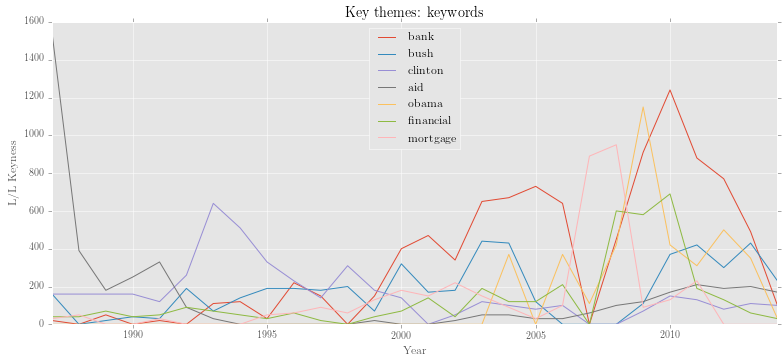

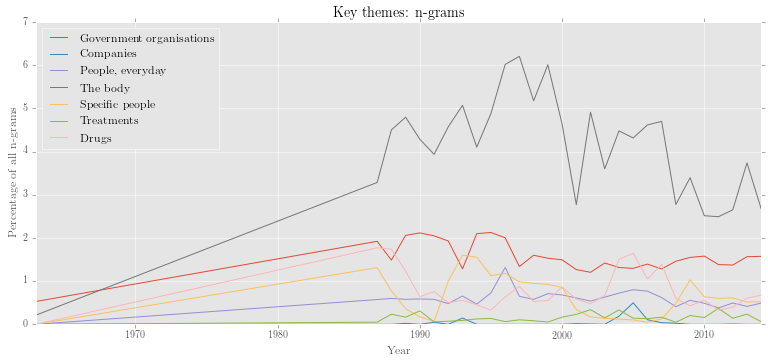

In [420]:
kwds = load_result('kwds')
plotter('Key themes: keywords', kwds.results.drop('1963'), y_label = 'L/L Keyness')
plotter('Key themes: n-grams', ngms.results, y_label = 'Percentage of all n-grams')

So, we can now do some pretty cool stuff in just a few lines of code. Let's concordance the top five keywords, looking at the year in which they are most key:

In [42]:
import os
# iterate through results
for index, w in enumerate(list(kwds.results)[:5]):
    # get the year with most occurrences
    top_year = kwds.results[w].idxmax()
    # print some info
    print '\n%d: %s, %s' % (index + 1, w, str(top_year))
    # get path to that subcorpus
    top_dir = os.path.join(annual_trees, str(top_year))
    # make a tregex query with token start and end defined
    query = r'/(?i)^' + w + r'$/'
    # do concordancing
    lines = conc(top_dir, query, random = True, n = 10)


1: bank, 2010

15:43:56: Getting concordances for data/nyt/years/2010 ... 
          Query: /(?i)^bank$/

0                                   But the   bank   , Germany 's largest and most           
1     the president of the European Central   Bank   , now Jean-Claude Trichet of France     
2    decision to release the results of the   bank   tests , the heads of state and          
3  gradually broke down , partly because of   bank   deregulation , but mainly because of the
4      under guidelines negotiated with the   bank   's clients                              
5   million in debt that they owed to Royal   Bank   of Scotland , or risk surrendering      
6   of such firms , '' the European Central   Bank   said , without naming any countries or  
7     risk management helped the investment   bank   solidify its position as a top-tier     
8                                       Our   bank   regulators were not , as they would like
9     , in some cases it is necessary for a   b

### Collocates

You can easily generate collocates for corpora, subcorpora or concordance lines:

In [135]:
from corpkit import collocates
conc_colls = collocates(adj_lines)
for coll in conc_colls:
    print coll

subc_colls = collocates('data/nyt/years/2003')
for coll in subc_colls:
    if 'risk' not in coll:
        print coll

[0, u'blood', u'pressure']
[1, u'breast', u'cancer']
[2, u'bush', u'administration']
[4, u'heart', u'disease']
[9, u'last', u'week']
[10, u'last', u'year']
[11, u'new', u'york']
[12, u'officials', u'said']
[14, u'president', u'bush']
[24, u'said', u'would']
[26, u'take', u'risks']
[27, u'united', u'states']
[29, u'years', u'ago']


With the `collocates()` function, you can specify the maximum distance at which two tokens will be considered collocates.

In [136]:
colls = collocates(adj_lines, window = 3)
for coll in colls:
    print coll

[0, u'less', u'risky']
[1, u'risky', u'plan']
[2, u'risky', u'strategy']


### quicktree() and searchtree()

The two functions are useful for visualising and searching individual syntax trees. They have proven useful as a way to practice your Tregex queries.

You could get trees by using `conc()` with a very large window and *trees* set to *True*. Alternatively, you can open files in the data directory directly, and paste them in.

`quicktree()` generates a visual representation of a parse tree. Here's one from 1989:

In [138]:
tree = '(ROOT (S (NP (NN Pre-conviction) (NN attachment)) (VP (VBZ carries) (PP (IN with) (NP (PRP it))) (NP (NP (DT the) (JJ obvious) (NN risk)) (PP (IN of) (S (VP (VBG imposing) (NP (JJ drastic) (NN punishment)) (PP (IN before) (NP (NN conviction)))))))) (. .)))'
# currently broken!
# quicktree(tree)

`searchtree()` requires a tree and a Tregex query. It will return a list of query matches.

In [139]:
from corpkit import searchtree
print searchtree(tree, r'/VB.?/ >># (VP $ NP)')
print searchtree(tree, r'NP')

['carries']
['Pre-conviction attachment', 'it', 'the obvious risk of imposing drastic punishment before conviction', 'the obvious risk', 'drastic punishment', 'conviction']


Now you're familiar with the corpus and functions. In the sections below, we'll perform a formal, followed by a functional, analysis of risk. Let's start with the formal side of things:

### Word classes of risk words in the NYT

In formal grammar, as we saw earlier, risk words can be nouns, verbs, adjectives and adverbs. Though we've seen that there are a lot of nouns, and that nouns are becoming more frequent, we don't yet know whether or not nouns are becoming more frequent in the NYT generally. To test this, we can do as follows:

In [140]:
# 'any' is a special query, which finds any tag if 'pos'
# and any word if 'words'.
baseline = interrogator(annual_trees, 'pos', 'any', lemmatise = True)
risk_pos = interrogator(annual_trees, 'pos', r'__ < /(?i).?\brisk.?/', lemmatise = True)

 00:40:29: Finished! 6 unique results, 376266 total.


In the cell above, the `lemmatise = True` option will convert tags like `'NNS'` to `'Noun'`.

In [141]:
quickview(baseline.results, n = 10)

  0: Noun (n=6164445)
  1: Verb (n=3299115)
  2: Preposition (n=2521695)
  3: Determiner (n=2047470)
  4: Adjective (n=1716147)
  5: Adverb (n=884301)
  6: Pronoun (n=833389)
  7: Coordinating conjunction (n=663931)
  8: to (n=543740)
  9: Cardinal number (n=317706)


In [142]:
quickview(risk_pos.results)

  0: Noun (n=289209)
  1: Adjective (n=45604)
  2: Verb (n=41395)
  3: Adverb (n=49)
  4: Cardinal number (n=5)
  5: x (n=4)


Now, we can calculate the percentage of the time that a noun is a risk noun (and so on).

In [402]:
open_words = ['Noun', 'Verb', 'Adjective', 'Adverb']
maths_done = editor(risk_pos.results, '%', baseline.results, sort_by = 'total', just_entries = open_words, skip_subcorpora = [1963])


***Processing results***

Skipping 1 subcorpora:
    1963

Keeping 4 entries:
    Noun
    Verb
    Adjective
    Adverb

***Done!***



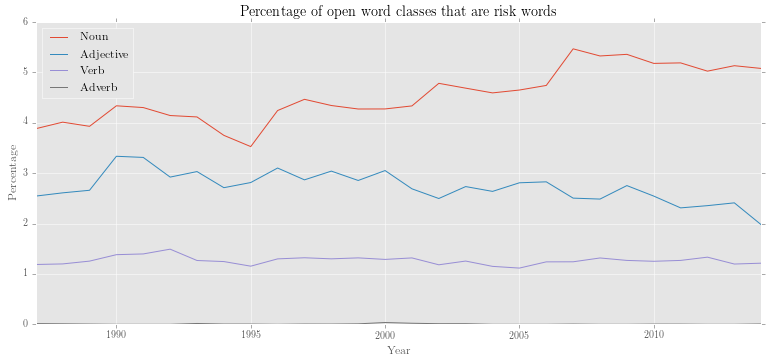

In [403]:
plotter('Percentage of open word classes that are risk words', maths_done.results, y_label = 'Percentage')

Neat, huh? We can see that nominalisation of risk is a very real thing.

Our problem, however, is that formal categories like noun and verb only take us so far: in the phrase "risk metrics", risk is a noun, but performs a modifier function, for example. In the next section, we interrogate the corpus for *functional*, rather than *formal* categorisations of risk words.

Before we start our corpus interrogation, we'll also present a *very* brief explanation of *Systemic Functional Linguistics*&mdash;the theory of language that underlies our analytical approach.

### Functional linguistics

*Functional linguistics* is a research area concerned with how *realised language* (lexis and grammar) work to achieve meaningful social functions. One functional linguistic theory is *Systemic Functional Linguistics*, developed by Michael Halliday.

In [145]:
from IPython.display import HTML
HTML('<iframe src=http://en.mobile.wikipedia.org/wiki/Michael_Halliday?useformat=mobile width=700 height=350></iframe>')

Central to the theory is a division between **experiential meanings** and **interpersonal meanings**.

* Experiential meanings communicate what happened to whom, under what circumstances.
* Interpersonal meanings negotiate identities and role relationships between speakers 

Halliday argues that these two kinds of meaning are realised **simultaneously** through different parts of English grammar.

* Experiential meanings are made through **transitivity choices**.
* Interpersonal meanings are made through **mood choices**

Here's one visualisation of it. We're concerned with the two left-hand columns. Each level is an abstraction of the one below it.

<br>
<img style="float:left" src="https://raw.githubusercontent.com/interrogator/risk/master/images/egginsfixed.jpg" alt="SFL metafunctions"  height="500" width="800" />
<br>

Transitivity choices include fitting together configurations of:

* Participants (*a man, green bikes*)
* Processes (*sleep, has always been, is considering*)
* Circumstances (*on the weekend*, *in Australia*)

Mood features of a language include:

* Mood types (*declarative, interrogative, imperative*)
* Modality (*would, can, might*)
* Lexical density&mdash;the number of words per clause, the number of content to non-content words, etc.

Lexical density is usually a good indicator of the general tone of texts. The language of academia, for example, often has a huge number of nouns to verbs. We can approximate an academic tone simply by making nominally dense clauses: 

      The consideration of interest is the potential for a participant of a certain demographic to be in Group A or Group B.

Notice how not only are there many nouns (*consideration*, *interest*, *potential*, etc.), but that the verbs are very simple (*is*, *to be*).

In comparison, informal speech is characterised by smaller clauses, and thus more verbs.

      A: Did you feel like dropping by?
      B: I thought I did, but now I don't think I want to

Here, we have only a few, simple nouns (*you*, *I*), with more expressive verbs (*feel*, *dropping by*, *think*, *want*)

> **Note**: SFL argues that through *grammatical metaphor*, one linguistic feature can stand in for another. *Would you please shut the door?* is an interrogative, but it functions as a command. *invitation* is a nominalisation of a process, *invite*. We don't have time to deal with these kinds of realisations, unfortunately.

### Functional roles of *risk* in the NYT

> *A discourse analysis that is not based on grammar is not an analysis at all, but simply a running commentary on a text.* - [M.A.K. Halliday, 1994]()

Our analysis proceeded according to the description of the transitivity system in *systemic functional grammar* ([SFG: see Halliday & Matthiessen, 2004](#ref:hallmat)).

The main elements of the transitivity system are *participants* (the arguments of main verbs) and *processes* (the verbal group). Broadly speaking, processes can be modified by circumstances (adverbs and prepositional phrases, and participants can be modified through epithets, classifiers (determiners, adjectives, etc).

> This is an oversimplification, of course. Grab a copy of the [*Introduction to Functional Grammar*](http://www.tandfebooks.com/isbn/9780203783771) to find out more.

Risk words can potentially be participants, processes or modifiers.

*Risk-as-participant*: any nominal argument of a process that is headed by a risk word. *Examples*:

* *the big risk*
* *considerable risk*
* *the risk of cancer*
* *risk-management*

*Risk-as-process*: risk word as the rightmost component of a VP. **Examples**:

* *he risked his life*
* *the company could potentially risk it*

*Risk-as-modifier*: any risk word that modifies a participant or process. This includes many adjectival risk words and many risk words appearing within prepositional or adverbial phrases. **Examples**:

* *the chance of risk*
* *risky business*
* *they riskily arranged to meet*

To find the distributions of these, we define three (very long and complicated) Tregex queries as sublists of titles and patterns under *query*. We then use `multiquery()` to search for each query in turn.

In [405]:
from corpkit import multiquery
query = (['Participant', r'/(?i).?\brisk.?/ > (/NN.?/ >># (NP !> PP !> (VP <<# (/VB.?/ < '
        '/(?i)\b(take|takes|taking|took|taken|run|runs|running|ran|pose|poses|posed|posing)\b/)))) | >># (ADJP > VP)'], 
    ['Process', r'VP !> VP << (/VB.?/ < /(?i).?\brisk.?/) | > VP <+(VP) (/VB.?/ < '
        '/(?i)(take|taking|takes|taken|took|run|running|runs|ran|put|putting|puts|pose|poses|posed|posing)/'
        '>># (VP < (NP <<# (/NN.?/ < /(?i).?\brisk.?/))))'], 
    ['Modifier', r'/(?i).?\brisk.?/ !> (/NN.?/ >># (NP !> PP !> (VP <<# (/VB.?/ < '
        '/(?i)\b(take|takes|taking|took|taken|run|runs|running|ran|pose|poses|posed|posing)\b/)))) & !>># '
        '(ADJP > VP) & !> (/VB.?/ >># VP) & !> (/NN.?/ >># (NP > (VP <<# (/VB.?/ < /(?i)\b('
            'take|takes|taking|took|taken|run|runs|running|ran|pose|poses|posed|posing)\b/))))'])
functional_role = multiquery(annual_trees, query)

In [404]:
ppm = editor(functional_role.results, '%', allwords.totals)


***Processing results***

***Done!***



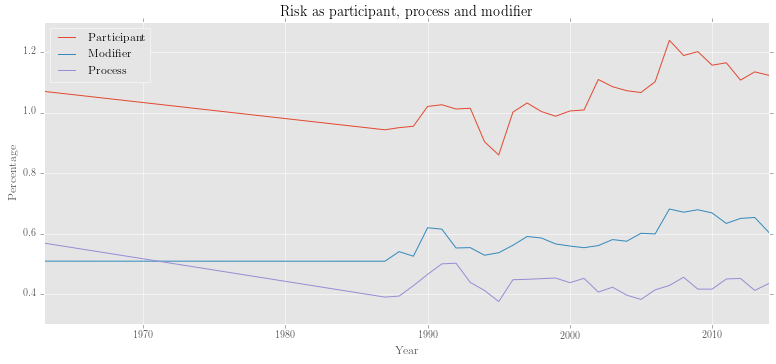

In [406]:
plotter('Risk as participant, process and modifier', ppm.results)

Here we can see that modifier forms are become more frequent over time, and have overtaken risk processes. Later, we determine which modifier forms in particular are becoming more common.

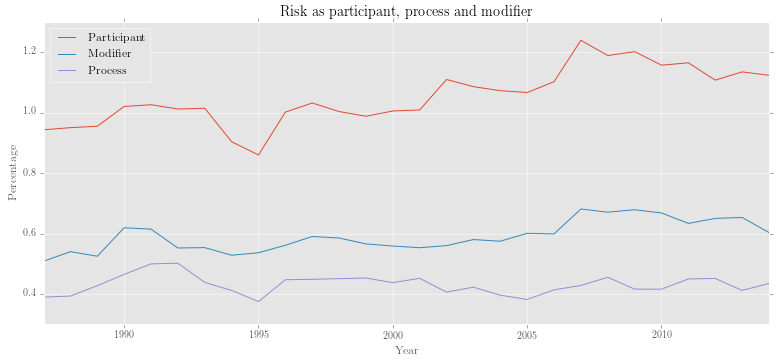

In [407]:
# Perhaps you want to see the result without 1963?
plotter('Risk as participant, process and modifier', ppm.results.drop('1963'))

### Risk as participant

> *You shall know a word by the company it keeps.* - [J.R. Firth, 1957](#ref:firth)

Functionally, *risk* is most commonly a participant in the NYT. This gives us a lot of potential areas of interest. We'll go through a few here, but there are plenty of other things that we have to leave out for reasons of space.

### Process types for participant risk

Here, we need to import verbose regular expressions that match any relational, verbal or mental process.

In [152]:
from dictionaries.process_types import processes
print processes.relational
print processes.verbal

(?i)\b((sound{0,2}|look{0,2}|seem{0,2}|appear{0,2})(s|es|ed|ing|)|(become|becomes|became|become|becoming|appear|appears|feel|feels|felt|feeling|smell|smells|smelled|smelt|smelling|be|was|been|being|are|were|is|am|[^a-z]s|[^a-z]m|[^a-z]re|have|has|had|had|having|[^a-z]d|[^a-z]ve))\b
(?i)\b((accede{0,2}|add{0,2}|admit{0,2}|advise{0,2}|advocate{0,2}|allege{0,2}|announce{0,2}|answer{0,2}|apprise{0,2}|argue{0,2}|ask{0,2}|assert{0,2}|assure{0,2}|attest{0,2}|aver{0,2}|avow{0,2}|bark{0,2}|beg{0,2}|bellow{0,2}|blubber{0,2}|boast{0,2}|brag{0,2}|cable{0,2}|claim{0,2}|comment{0,2}|complain{0,2}|confess{0,2}|confide{0,2}|confirm{0,2}|contend{0,2}|convey{0,2}|counsel{0,2}|declare{0,2}|demand{0,2}|disclaim{0,2}|disclose{0,2}|divulge{0,2}|emphasise{0,2}|emphasize{0,2}|exclaim{0,2}|explain{0,2}|forecast{0,2}|gesture{0,2}|grizzle{0,2}|guarantee{0,2}|hint{0,2}|holler{0,2}|indicate{0,2}|inform{0,2}|insist{0,2}|intimate{0,2}|mention{0,2}|moan{0,2}|mumble{0,2}|murmur{0,2}|mutter{0,2}|note{0,2}|object{0,2}|o

We can use these in our Tregex queries to look for the kinds of processes participant risks are involved in. First, let's get a count for all processes with risk participants:

In [153]:
# get total number of processes with risk participant
query = r'/VB.?/ ># (VP ( < (NP <<# /(?i).?\brisk.?/) | >+(/.P$/) (VP $ (NP <<# /(?i).?\brisk.?/))))'
proc_w_risk_part = interrogator(annual_trees, 'count', query)

### Relational processes with risk participant

In [154]:
# subj_query = r'/VB.?/ < %s ># (VP >+(/.P$/) (VP $ (NP <<# /(?i).?\brisk.?/)))' % processes.relational
# obj_query = r'/VB.?/ < %s ># (VP < (NP <<# /(?i).?\brisk.?/))'  % processes.relational
query = r'/VB.?/ < /%s/ ># (VP ( < (NP <<# /(?i).?\brisk.?/) | >+(/.P$/) (VP $ (NP <<# /(?i).?\brisk.?/))))' % processes.relational
relationals = interrogator(annual_trees, 'words', query, lemmatise = True)

 08:02:37: Finished! 5 unique results, 23135 total.


In [408]:
rels = editor(relationals.results, '%', proc_w_risk_part.totals)


***Processing results***

***Done!***



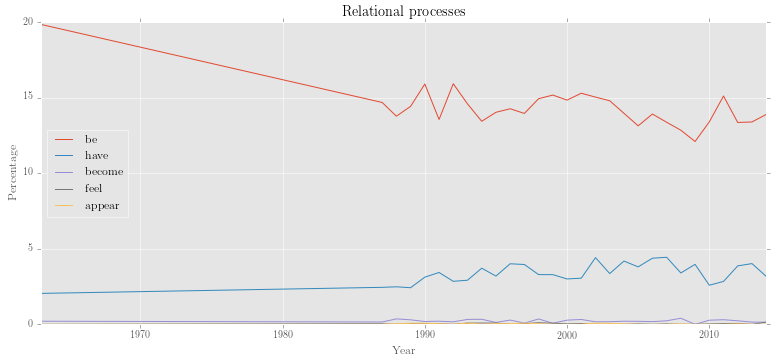

In [409]:
plotter('Relational processes', rels.results)

### Adjectives modifying risk

First, we can look at adjectives that modify a participant risk.

In [161]:
query = r'/JJ.?/ > (NP <<# /(?i).?\brisk.?/ ( > VP | $ VP))'
adj_modifiers = interrogator(annual_trees, 'words', query, lemmatise = True)

 08:18:40: Finished! 1159 unique results, 27234 total.



***Processing results***

***Done!***



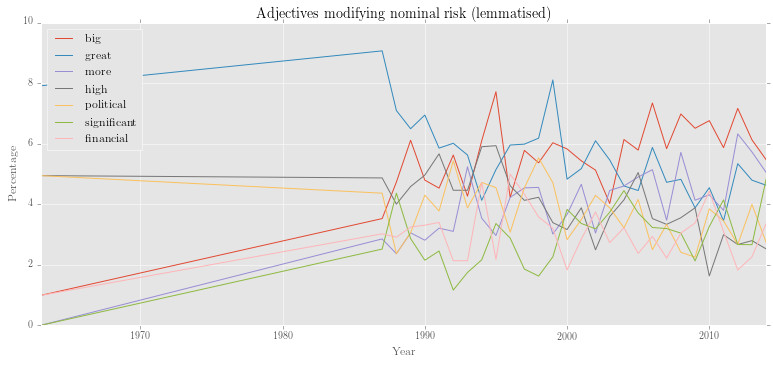

In [410]:
adj = editor(adj_modifiers.results, '%', adj_modifiers.totals)
plotter('Adjectives modifying nominal risk (lemmatised)', adj.results, num_to_plot = 7)

Yuck! That doesn't tell us much. Let's try visualising the data in a few different ways. First, let's see what the top results look like...

In [169]:
quickview(adj_modifiers.results)

  0: big (n=1596)
  1: great (n=1425)
  2: more (n=1174)
  3: high (n=989)
  4: political (n=962)
  5: significant (n=848)
  6: financial (n=828)
  7: potential (n=735)
  8: serious (n=728)
  9: real (n=667)
 10: such (n=494)
 11: little (n=459)
 12: calculated (n=434)
 13: systemic (n=428)
 14: huge (n=406)
 15: own (n=398)
 16: substantial (n=361)
 17: excessive (n=346)
 18: low (n=342)
 19: new (n=326)
 20: less (n=317)
 21: considerable (n=304)
 22: few (n=268)
 23: other (n=264)
 24: same (n=263)


OK, here are some ideas:


***Processing results***

Skipping 1086 entries:
    great
    political
    significant
    financial
    potential
    serious
    little
    calculated
    systemic
    substantial
... and 1076 more ... 


***Done!***


***Processing results***

Keeping 481 entries:
    significant
    calculated
    substantial
    considerable
    environmental
    unnecessary
    additional
    cardiovascular
    particular
    acceptable
... and 471 more ... 


***Done!***


***Processing results***

Keeping 4 entries:
    more
    high
    calculated
    potential


***Done!***



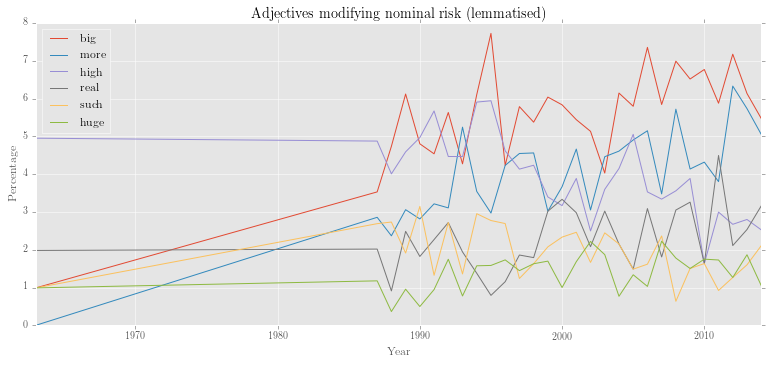

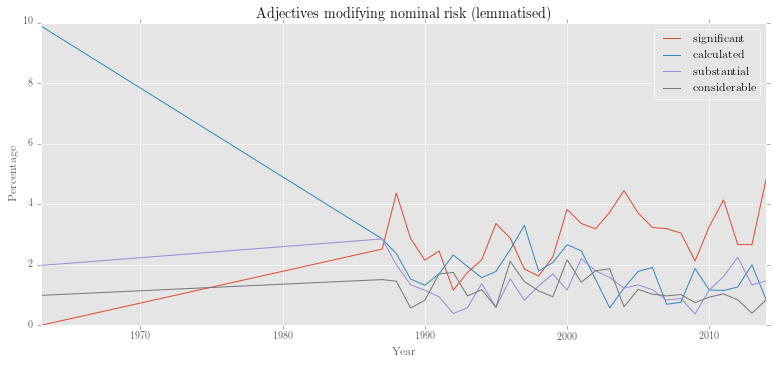

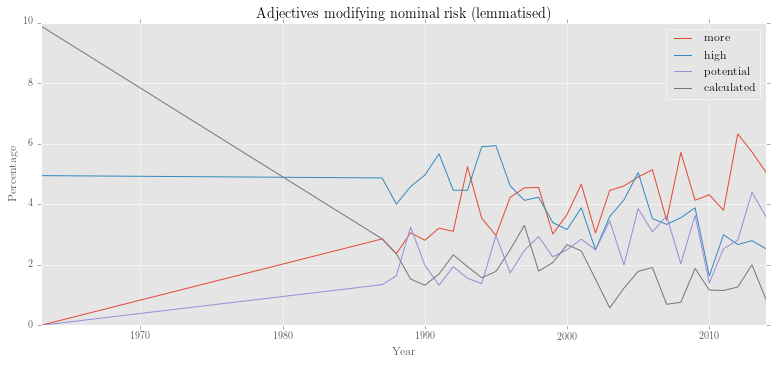

In [567]:
# remove words with five or more letters
small_adjs = editor(adj_modifiers.results, '%', adj_modifiers.totals, skip_entries = r'.{5,}')

plotter('Adjectives modifying nominal risk (lemmatised)', small_adjs.results, num_to_plot = 6)

#get results with seven or more letters
big_adjs = editor(adj_modifiers.results, '%', adj_modifiers.totals, just_entries = '.{10,}')
plotter('Adjectives modifying nominal risk (lemmatised)', big_adjs.results, num_to_plot = 4)

#get a few interesting points
lst = ['more', 'high', 'calculated', 'potential']
select_adjs = editor(adj_modifiers.results, '%', adj_modifiers.totals, just_entries = lst)
plotter('Adjectives modifying nominal risk (lemmatised)', select_adjs.results, 
    num_to_plot = 4)

Wow! What's happening with *calculated risk* in 1963? Let's modify the original Tregex query a little and use `conc()` to find out.

In [171]:
### old query: r'/JJ.?/ > (NP <<# /(?i).?\brisk.?/ ( > VP | $ VP))'
calculated_risk = r'/JJ.?/ < /(?i)calculated/> (NP <<# /(?i).?\brisk.?/ ( > VP | $ VP))'
# remove '( > VP | $ VP)' from the line above to get more instances
lines = conc('data/nyt/years/1963', calculated_risk)


08:26:59: Getting concordances for data/nyt/years/1963 ... 
          Query: /JJ.?/ < /(?i)calculated/> (NP <<# /(?i).?\brisk.?/ ( > VP | $ VP))

0   , in Cuba , Chairman Khrushchev took a   calculated   risk by installing long-range missiles  
1                      Kennedy has taken a   calculated   risk here                               
2         , the foreman last year , took a   calculated   risk and rebuilt the pitching staff with
3     a study in depth had been made was a   calculated   risk                                    
4                                This is a   calculated   risk , but in the light of recent       
5                  U A.M. , `` Prayer Is a   Calculated   Risk                                    
6     Unite '' States is still surrounding   Calculated   Risk some basic forms of economic       
7                            London took a   calculated   risk in gambling everything on success  
8                                 It was a   calculated   ris

### Risk of ... ?

Next, we'll look at risk of (noun) constructions, as in:

In [172]:
lines = conc('data/nyt/years/1988', r'/NN.?/ >># (NP > (PP <<# /(?i)of/ > (NP <<# (/NN.?/ < /(?i).?\brisk.?/))))', n = 25, random = True)


08:27:09: Getting concordances for data/nyt/years/1988 ... 
          Query: /NN.?/ >># (NP > (PP <<# /(?i)of/ > (NP <<# (/NN.?/ < /(?i).?\brisk.?/))))

0    women at especially high risk of breast          cancer   '' should '' curtail their alcohol      
1        to discourage those at high risk of            AIDS   from donating                           
2                      A Low Risk of Disease            Seen   From Syringes on Beaches                
3     But the risks of official intervention            pall   compared with the certain costs of delay
4   for change can be made to seem a risk of            loss   , a gain by others at their expense     
5       telling whether they were at risk of       infection   outside the laboratory                  
6        by some people at high risk of AIDS       infection   who were declared free of the virus in  
7    problems increase the public 's risk of        exposure   , '' the investigators said             
8      sharply

Notice that singular and plural forms may be in the results: both *substance* and *substances* are returned, and would be counted as unique items.

If we want to ignore the difference between singular and plural (or different inflections of a verb), we need to use a *lemmatiser*. Luckily, `interrogator()` has one built in.

When lemmatisation is necessary, we can pass a `lemmatise = True` parameter to `interrogator()`.

Lemmatisation requires knowing the part of speech of the input. `interrogator()` determines this by looking at the first part of the Tregex query: if it's `/JJ.?/`, the lemmatiser will be told that the word is an adjective. If the part of speech cannot be located, noun is used as a default. You can also manually pass a tag to the lemmatiser with a `lemmatag = 'n/v/r/a'` option.

In [173]:
# Risk of (noun)
query = r'/NN.?/ >># (NP > (PP <<# /(?i)of/ > (NP <<# (/NN.?/ < /(?i).?\brisk.?/))))'
risk_of = interrogator(annual_trees, 'words', query, lemmatise = True)

 08:38:20: Finished! 3302 unique results, 50062 total.



***Processing results***

***Done!***


***Processing results***

Keeping subcorpora:
    1999--2013

***Done!***



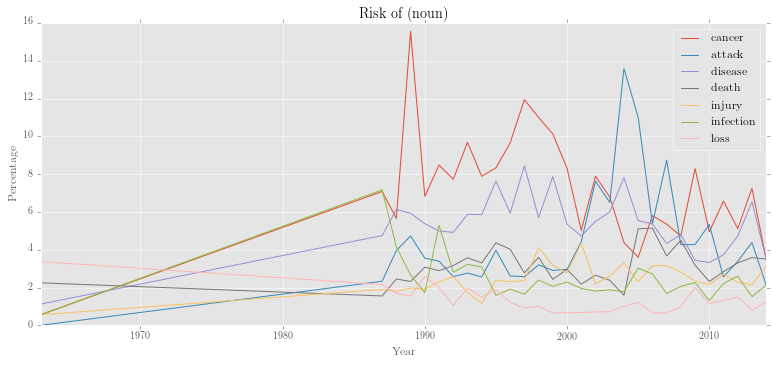

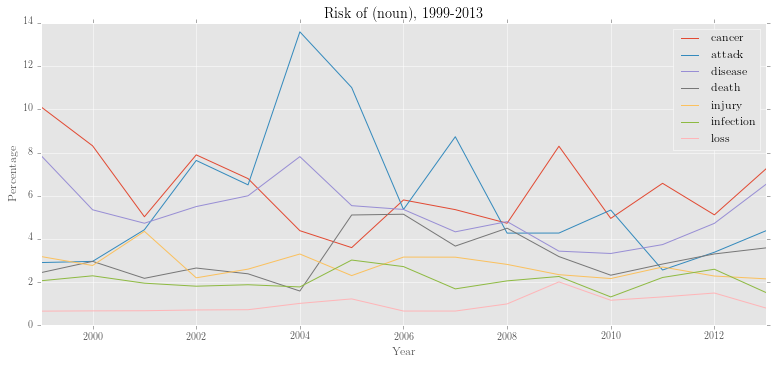

In [412]:
rel_riskof = editor(risk_of.results, '%', risk_of.totals)
plotter('Risk of (noun)', rel_riskof.results)
plotter('Risk of (noun), 1999-2013', editor(rel_riskof.results, span_subcorpora = [1999,2013]).results)

### A cautionary tale ...

At one point in our investigation, we looked specifically for military risks. From these results, we saw that *risk of attack* and *risk of war* were common. So, we plotted them:

In [175]:
quickview(risk_of, n = 20)

  0: cancer (n=3354)
  1: attack (n=2699)
  2: disease (n=2665)
  3: death (n=1604)
  4: injury (n=1294)
  5: infection (n=1170)
  6: loss (n=591)
  7: failure (n=588)
  8: problem (n=576)
  9: default (n=558)
 10: inflation (n=528)
 11: war (n=512)
 12: stroke (n=489)
 13: complication (n=460)
 14: damage (n=385)
 15: harm (n=376)
 16: transmission (n=330)
 17: diabetes (n=320)
 18: recession (n=318)
 19: suicide (n=317)



***Processing results***

Keeping 2 entries:
    attack
    war


***Done!***



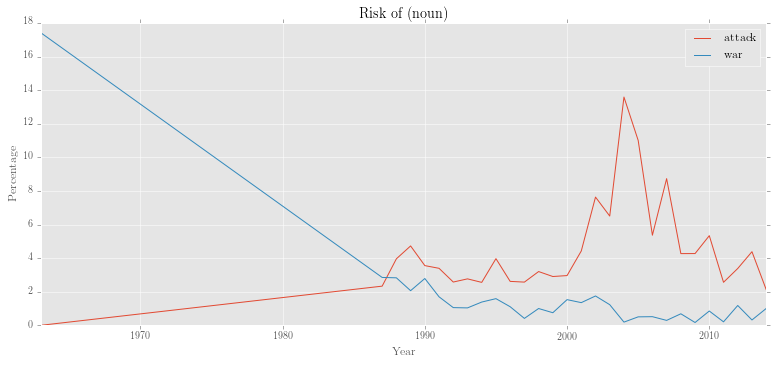

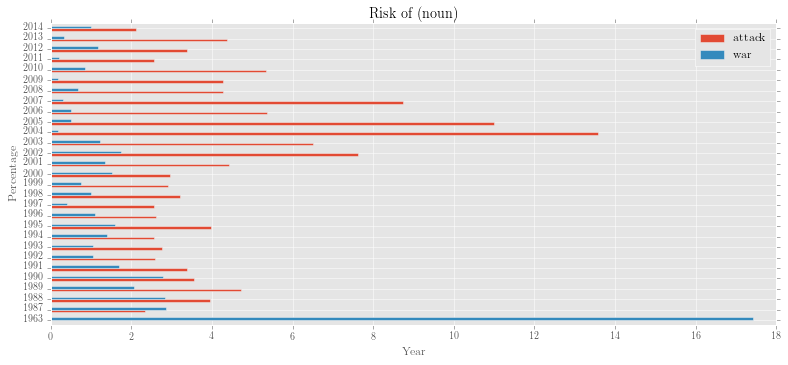

In [568]:
military = editor(risk_of.results, '%', risk_of.totals, just_entries = ['attack', 'war'])
plotter('Risk of (noun)', military.results)
# barh, just for fun
plotter('Risk of (noun)', military.results, kind = 'barh')

 We thought it was interesting how *risk of attack* rose in frequency shortly after 9/11. So, we decided to look more closely at *risk of attack*:

In [177]:
attackrisk = r'/NN.?/ < /(?i)attack.?/ >># (NP > (PP <<# /(?i)of/ > (NP <<# (/NN.?/ < /(?i).?\brisk.?/))))'
lines = conc('data/nyt/years/2004', attackrisk, n = 15, random = True) 


08:38:29: Getting concordances for data/nyt/years/2004 ... 
          Query: /NN.?/ < /(?i)attack.?/ >># (NP > (PP <<# /(?i)of/ > (NP <<# (/NN.?/ < /(?i).?\brisk.?/))))

0       The group says the risk of terrorist   attacks   justifies more spending , and it is busy
1    angina can reduce their risk of a heart    attack   with a variety of medications           
2     Re '' U.S. Warns of High Risk of Qaeda    Attack   '' -LRB- front page , Aug. 2 -RRB       
3       also bringing down the risk of heart    attack   , progressive heart failure and other   
4         , may increase the risk of a heart    attack   or stroke in heart bypass surgery       
5     Vioxx might increase the risk of heart   attacks   first emerged three years ago , in a    
6       the drug increased the risk of heart   attacks   and strokes in some patients            
7         , might increase the risk of heart    attack   or stroke in coronary artery bypass     
8    that Vioxx increased the risks of heart 

Whoops. We were wrong. Almost all occurrences actually referred to *heart attack*!

In [178]:
query = r'/NN.?/ < /(?i)\b(heart|terror).?/ $ (/NN.?/ < /(?i)\battack.?/ >># (NP > (PP <<# /(?i)of/ > (NP <<# (/NN.?/ < /().?\brisk.?/)))))' 
terror_heart = interrogator(annual_trees, 'words', query, lemmatise = True)

 08:49:15: Finished! 2 unique results, 1949 total.


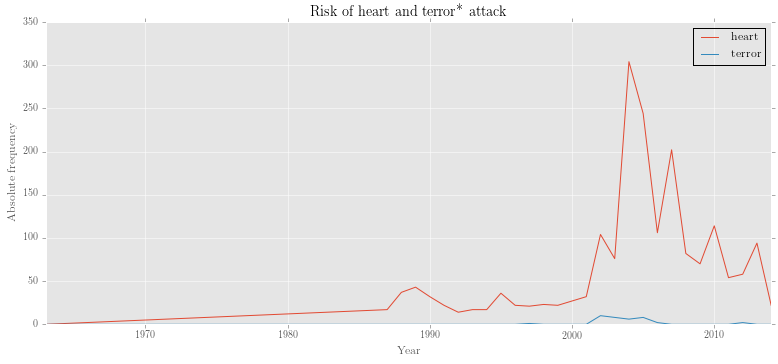

In [179]:
plotter('Risk of heart and terror* attack', terror_heart.results, num_to_plot = 2, legend = 'upper left')

So, we were a long way off-base. This is an ever-present danger in corpus linguistics. The decontextualisation needed to investigate the lexicogrammar of texts makes it easy to misunderstand (or worse, misrepresent) the data. Though concordancing is one of the oldest tasks in the corpus linguistic playbook, it remains a fundamental one, especially in discourse-analytic investigations.

> ... *why did heart attacks become a big deal in 2004, you ask? Stay tuned ...*

### Processes in which risk is subject/object

Here, we look at the kinds of predicators that occur when risk subject or object. Note that we remove *run/take/pose risk*, as these are actually verbal risks (see below).

By navigating parse trees in more complex ways, we can learn the kinds of processes risk as a participant is involved in.

In [180]:
query = (r'/VB.?/ !< /(?i)(take|taking|takes|taken|took|run|running|runs|ran|put|putting|puts|pose|poses|posing|posed)/' \
    r' > (VP ( < (NP <<# (/NN.?/ < /(?i).?\brisk.?/))) | >+(VP) (VP $ (NP <<# (/NN.?/ < /(?i).?\brisk.?/))))')
predicators = interrogator(annual_trees, 'words', query, lemmatise = True)

 08:59:33: Finished! 1491 unique results, 99218 total.



***Processing results***

***Done!***


***Processing results***

Skipping 1 entries:
    be

***Done!***



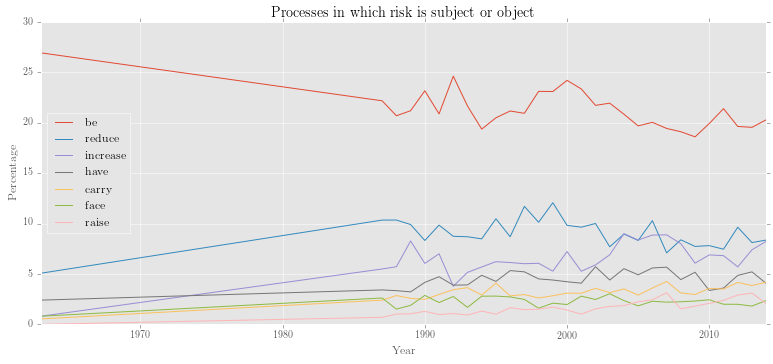

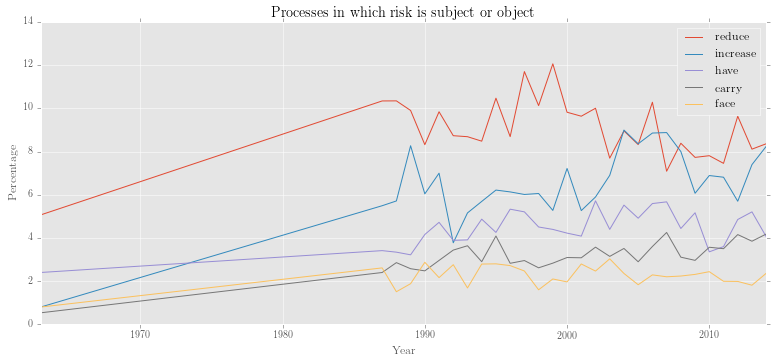

In [414]:
# Processes in which risk is subject/object
plotter('Processes in which risk is subject or object', editor(predicators.results, '%', predicators.totals).results, num_to_plot = 7)
# skip be:
plotter('Processes in which risk is subject or object', editor(predicators.results, 
'%', predicators.totals, skip_entries = ['be']).results, num_to_plot = 5)

Interesting! 

### Risk as process

When *risk* is the main verb in a clause (e.g. *don't risk it*), it is the process. There are other kinds of risk processes, however: when risk occurs as the first object argument of certain nouns, it may be classified as a *process-range configuration* (an SFL term). Searching the data reveals four other main kinds of risk process:

1. *to take risk*
2. *to run risk*
3. *to put at risk*
4. *to pose a risk*

In these cases, the expression is more or less idiomatic, and the main verb carries little semantic weight ([Eggins, 2004](#ref:eggins)). 

We tracked the relative frequency of each construction over time.

In [182]:
query = ([u'risk', r'VP <<# (/VB.?/ < /(?i).?\brisk.?\b/)'], 
    [u'take risk', r'VP <<# (/VB.?/ < /(?i)\b(take|takes|taking|took|taken)+\b/) < (NP <<# /(?i).?\brisk.?\b/)'], 
    [u'run risk', r'VP <<# (/VB.?/ < /(?i)\b(run|runs|running|ran)+\b/) < (NP <<# /(?i).?\brisk.?\b/)'], 
    [u'put at risk', r'VP <<# /(?i)(put|puts|putting)\b/ << (PP <<# /(?i)at/ < (NP <<# /(?i).?\brisk.?/))'], 
    [u'pose risk', r'VP <<# (/VB.?/ < /(?i)\b(pose|poses|posed|posing)+\b/) < (NP <<# /(?i).?\brisk.?\b/)'])
processes = multiquery(annual_trees, query)

In [415]:
proc_rel = editor(processes.results, '%', processes.totals)


***Processing results***

***Done!***



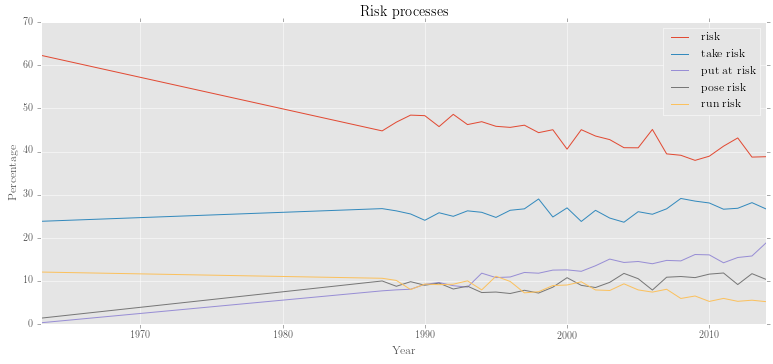

In [237]:
plotter('Risk processes', proc_rel.results)

Subordinate processes are often embedded within clauses containing a risk predicator, as in *Obama risks alienating voters*.

In [185]:
# to risk losing/being/having etc
query = r'VBG >># (VP > (S > (VP <<# (/VB.?/ < /(?i).?\brisk.?/))))'
risk_verbing = interrogator(annual_trees, 'words', query)

 11:07:47: Finished! 966 unique results, 13906 total.



***Processing results***

***Done!***



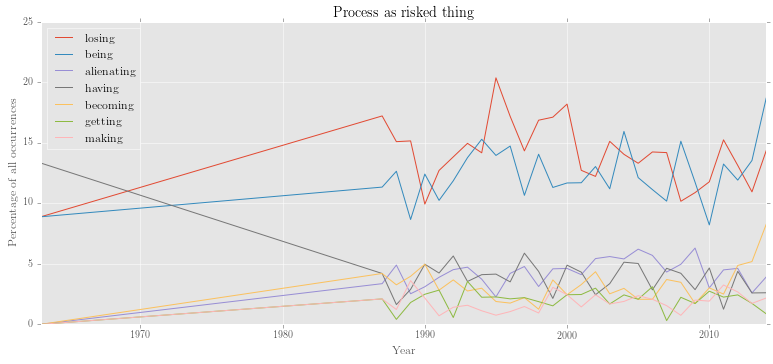

In [416]:
r_verbing = editor(risk_verbing.results, '%', risk_verbing.totals)
plotter('Process as risked thing', r_verbing.results, y_label = 'Percentage of all occurrences')

In this kind of risk process, the risker is typically a powerful member of society. While this is rather explicit in some cases (it's hard to image that a mechanic would risk alienating his/her apprentice), we can observe that this is the case for less obvious examples, like *to risk becoming*:

In [187]:
lines = conc('data/nyt/years/2013', r'VBG < /(?i)becom/ >># (VP > (S > (VP <<# (/VB.?/ < /(?i).?\brisk.?/))))', n = 15, random = True)


11:07:57: Getting concordances for data/nyt/years/2013 ... 
          Query: VBG < /(?i)becom/ >># (VP > (S > (VP <<# (/VB.?/ < /(?i).?\brisk.?/))))

0     left unaddressed , such practices risk   becoming   more and more entrenched , '' Ann       
1         the step as significant , it risks   becoming   the latest of many tentative moves      
2                          Switzerland risks   becoming   one of the most restrictive places for  
3        , the stage scene could have risked   becoming   an embarrassment for the brand , but Mr 
4         crisis in the European Union risks   becoming   a crisis of liberal democracy itself    
5      's new remarks that the church risked   becoming   a `` small chapel '' overly fixated on  
6       turning to what , strangely , risked   becoming   the most marginalized group of all : the
7          savings in this area , `` we risk   becoming   an unbalanced force , one that is well  
8        , warning that the euro area risked   becoming  

### Subjects of risk processes

In [9]:
query = r'/NN.?/ !< /(?i).?\brisk.?/ >># (@NP $ (VP <+(VP) (VP ( <<# (/VB.?/ < /(?i).?\brisk.?/) | <<# (/VB.?/ < /(?i)(take|taking|takes|taken|took|run|running|runs|ran|put|putting|puts|pose|poses|posed|posing)/) < (NP <<# (/NN.?/ < /(?i).?\brisk.?/))))))'
subj_of_risk_process = interrogator(annual_trees, 'words', query, lemmatise = True)

 23:12:08: Finished! 2491 unique results, 10049 total.


In [238]:
quickview(subj_of_risk_process)

  0: person (n=275)
  1: company (n=201)
  2: bank (n=137)
  3: investor (n=101)
  4: state (n=101)
  5: government (n=99)
  6: leader (n=71)
  7: man (n=70)
  8: president (n=61)
  9: player (n=58)
 10: woman (n=56)
 11: administration (n=53)
 12: bush (n=52)
 13: official (n=48)
 14: obama (n=48)
 15: democrat (n=48)
 16: american (n=46)
 17: republican (n=46)
 18: firm (n=46)
 19: member (n=44)
 20: team (n=40)
 21: israel (n=40)
 22: worker (n=39)
 23: network (n=38)
 24: party (n=38)



***Processing results***

Skipping 1 subcorpora:
    1963

***Done!***


***Processing results***

Skipping 1 subcorpora:
    1963

***Done!***


***Processing results***

Skipping 1 subcorpora:
    1963

***Done!***



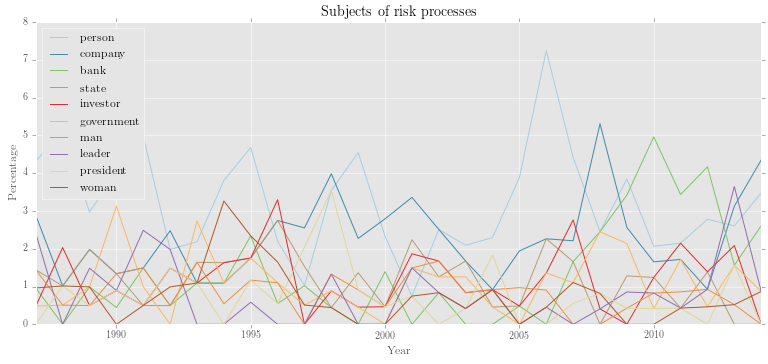

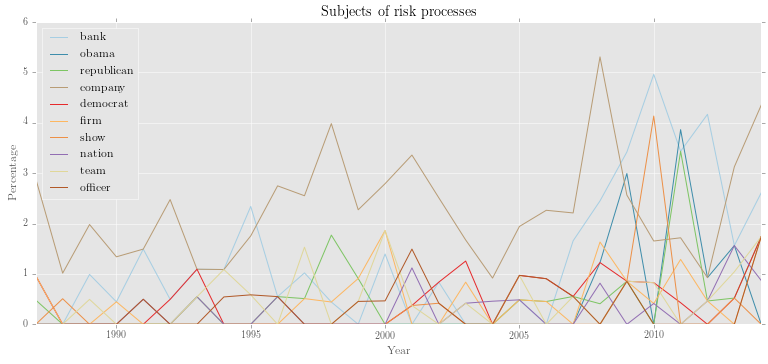

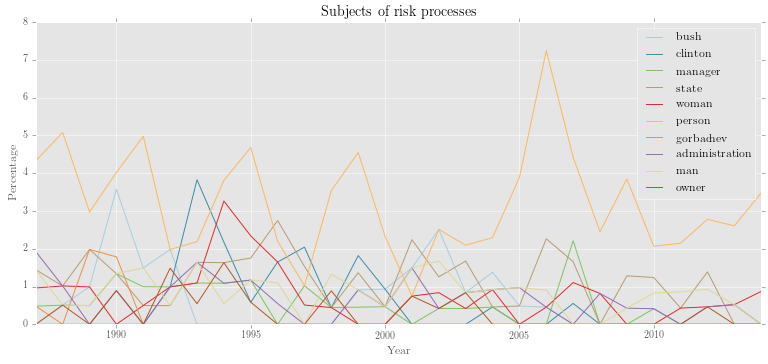

In [417]:
for s in ['total', 'increase', 'decrease']:
    with_sort = editor(subj_of_risk_process.results, '%', subj_of_risk_process.totals,
                       sort_by = s, skip_subcorpora = [1963])
    plotter('Subjects of risk processes', with_sort.results, num_to_plot = 10)

In [242]:
inst = ['government', 'bank', 'senator', 'republican', 
        'democrat', 'senate', 'congress', 'agency', 'firm']
peop = ['man', 'person', 'woman', 'child', 'baby', 'worker', 'consumer']
cats = editor(subj_of_risk_process.results, merge_entries = inst, newname = 'Institutions')
cats = editor(cats.results, merge_entries = peop, newname = 'People', 
              just_entries = ['Institutions', 'People'], sort_by = 'total')


***Processing results***

Merging 9 entries as "Institutions":
    government
    bank
    senator
    republican
    democrat
    senate
    congress
    agency
    firm


***Done!***


***Processing results***

Merging 7 entries as "People":
    man
    person
    woman
    child
    baby
    worker
    consumer

Keeping 2 entries:
    Institutions
    People


***Done!***



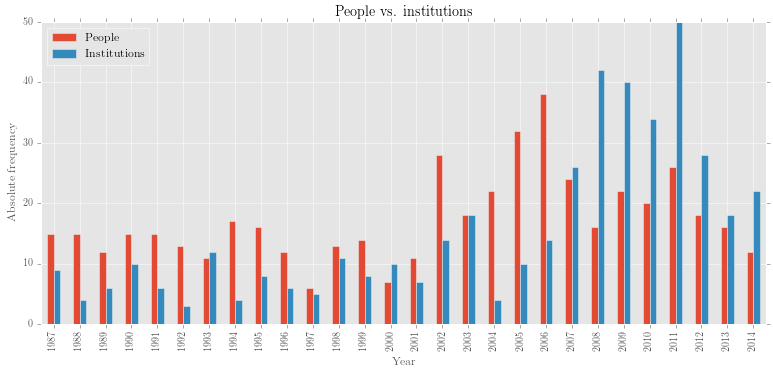

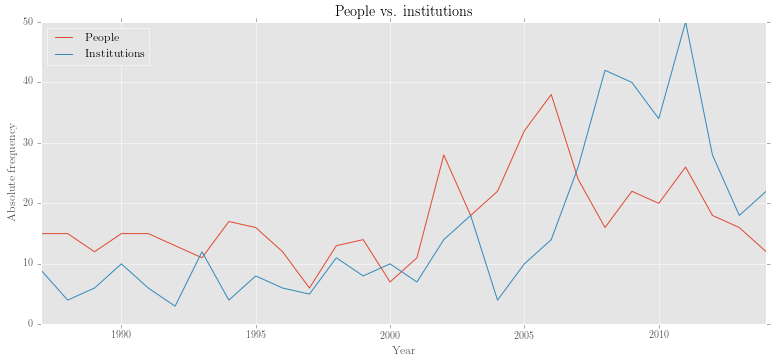

In [254]:
for k in ['bar', 'line']:
    plotter('People vs. institutions', cats.results.drop('1963'), kind = k)

### Risker value

A novel thing we can do with our data is determine the amount of time a word occurs in a given role. We know that Bush, Clinton, woman, bank, and child are common nouns in the corpus, but we do not yet know what percentage of the time they are playing a specific role in the risk frame.

To determine what percentage of the time these words take the role of risker, we start by counting their occurrences as risker, and in the corpus as a whole:

In [10]:
n_query = r'/NN.?/ !< /(?i).?\brisk.?/ >># NP'
noun_lemmata = interrogator(annual_trees, 'words', n_query, lemmatise = True)

 23:26:13: Finished! 78755 unique results, 4297593 total.


Then, we pass `editor()` a second list of results, rather than just totals, and use the `just_totals = True'` argument:

In [14]:
rel_risker = editor(subj_of_risk_process.results, '%', noun_lemmata.results, just_totals = True, sort_by = 'total')


***Processing results***

Threshold: 859

Removing 77822 entries below threshold:
    alcohol
    dealer
    search
    faith
    portion
    ...
    recitalist
    recirculation
    recife
    reciever
    landlubber
... and 77812 more ... 


***Done!***



Note that a `threshold` was printed. This number represents the minimum number of times an entry must occur in `noun_lemmata.totals` in order for the result to count.

We can pass in a threshold of our own. Note that if we set it to zero, unusual words are at the top of the results list:

In [15]:
rel_risker = editor(subj_of_risk_process.results, '%', noun_lemmata.results, 
             just_totals = True, threshold = 1, sort_by = 'total')
print rel_risker.results


***Processing results***

Threshold: 1



***Done!***

u.n.h.c.r.    100
passie        100
kamensky      100
...
point    0.014100
stock    0.012872
cost     0.011546
Name: Combined total, Length: 2491, dtype: float64


Aside from giving it an integer value, you can pass it `'low'`, `'medium'` or `'high'`.  `editor()` then creates thresholds based on the total total of `noun_lemmata.totals`. Passing no threshold results in '`medium` being used as the default (total words in second list / 5000):

In [16]:
#total / 10,000
tmp = editor(subj_of_risk_process.results, '%', noun_lemmata.results, 
    just_totals = True, threshold = 'low', sort_by = 'total')
#total / 5,000
tmp = editor(subj_of_risk_process.results, '%', noun_lemmata.results, 
    just_totals = True, threshold = 'medium', sort_by = 'total')
#total / 2,500
rel_risker = editor(subj_of_risk_process.results, '%', noun_lemmata.results, 
    just_totals = True, threshold = 'high', sort_by = 'total')


***Processing results***

Threshold: 429

Removing 77126 entries below threshold:
    complexity
    aug.
    carolina
    concession
    hurricane
    ...
    recitalist
    recirculation
    recife
    reciever
    landlubber
... and 77116 more ... 


***Done!***


***Processing results***

Threshold: 859

Removing 77822 entries below threshold:
    alcohol
    dealer
    search
    faith
    portion
    ...
    recitalist
    recirculation
    recife
    reciever
    landlubber
... and 77812 more ... 


***Done!***


***Processing results***

Threshold: 1718

Removing 78262 entries below threshold:
    minister
    cholesterol
    base
    reputation
    majority
    ...
    recitalist
    recirculation
    recife
    reciever
    landlubber
... and 78252 more ... 


***Done!***



OK, let's see what we have:

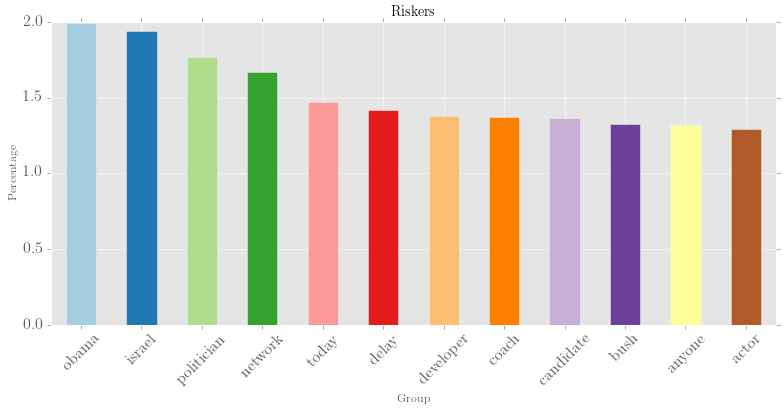

In [632]:
plotter('Riskers', rel_risker.results, num_to_plot = 12, kind = 'bar', fontsize = 16, rot = 45)

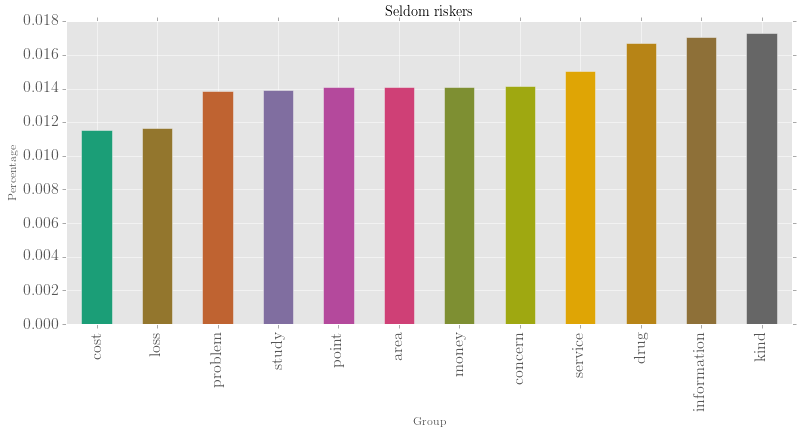

In [572]:
non_risked = editor(subj_of_risk_process.results, '%', noun_lemmata.results, 
    just_totals = True, threshold = 'low', sort_by = 'least', print_info = False)
plotter('Seldom riskers', non_risked.results, 
        num_to_plot = 12, kind = 'bar', colours = 'Dark2', fontsize = 16)

... and, one more exercise, just for fun. The `'self'` option for `editor()` calculates the modified results as percentage of their own total.

In [22]:
people = ['man', 'woman', 'child', 'baby', 'politician', 'senator', 'obama', 'clinton', 'bush']
selected = editor(subj_of_risk_process.results, '%', noun_lemmata.results, just_entries = people,
                          just_totals = True, threshold = 0, sort_by = 'total')
selected_self = editor(subj_of_risk_process.results, '%', 'self', just_entries = people,
                          just_totals = True, threshold = 0, sort_by = 'total')


***Processing results***

Keeping 9 entries:
    man
    woman
    child
    baby
    politician
    senator
    obama
    clinton
    bush

Threshold: 0



***Done!***


***Processing results***

Keeping 9 entries:
    man
    woman
    child
    baby
    politician
    senator
    obama
    clinton
    bush


***Done!***



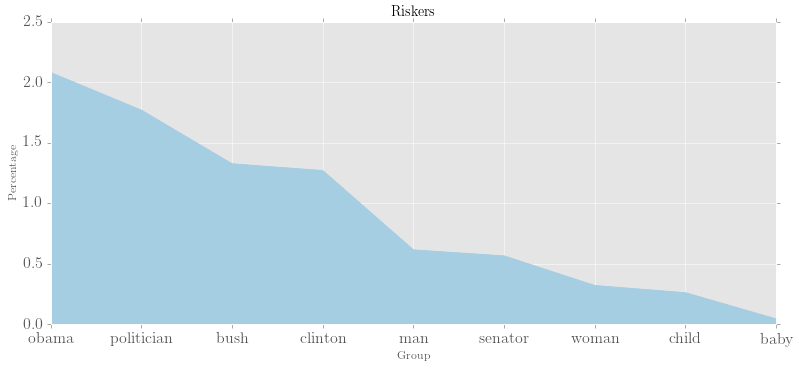

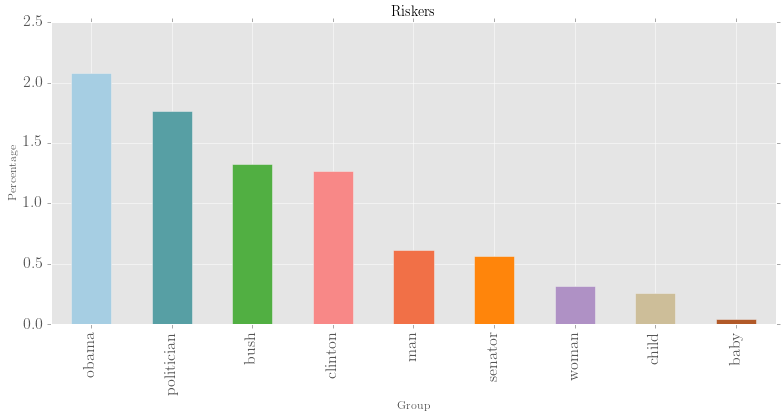

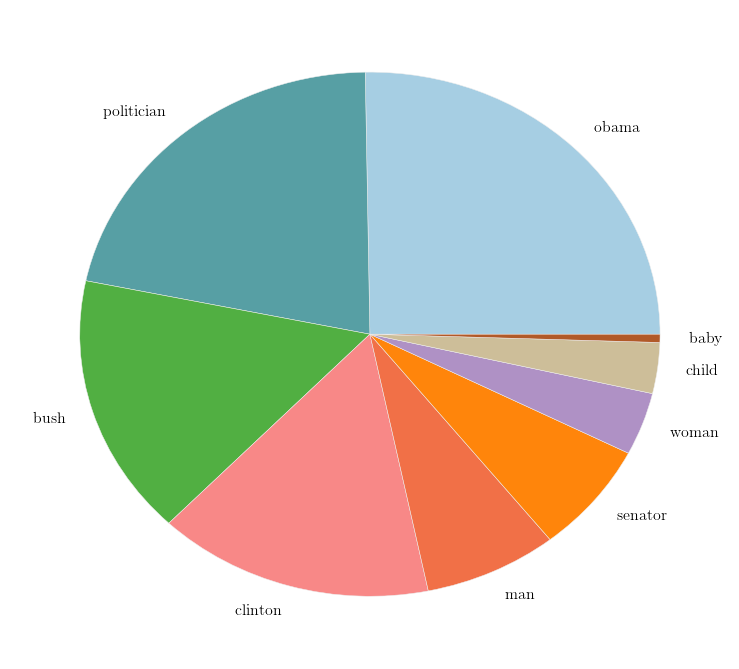

In [26]:
for k in ['area', 'bar', 'pie']:
    plotter('Riskers', selected.results, num_to_plot = 'all', kind = k, fontsize = 16, tex = True)

### Objects of risk processes

We can locate the most common objects of risk processes:

In [195]:
# Objects of risk processes
query = r'/NN.?/ >># (NP > (VP <<# (/VB.?/ < /(?i).?\brisk.?/)))'
risk_objects = interrogator(annual_trees, 'words', query, 
    lemmatise = True, titlefilter = False)

 12:53:18: Finished! 2226 unique results, 22599 total.


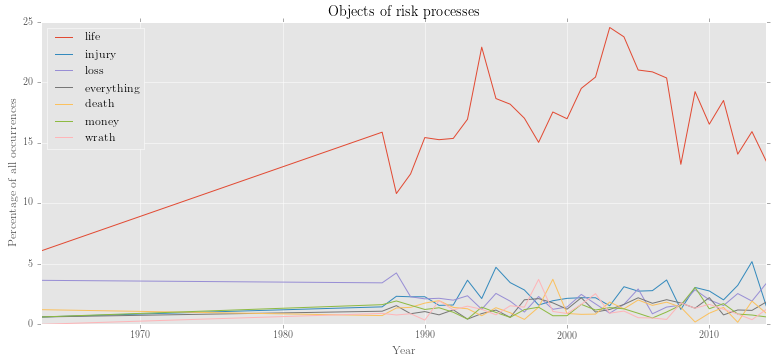

In [573]:
plotter('Objects of risk processes', editor(risk_objects.results, 
    '%', risk_objects.totals, print_info = False).results, y_label = 'Percentage of all occurrences')

Notice that both the *potential harm* and *risked things* can fit in this position. We can view the most common results and create new lists for risked things/potential harms with *surgeon()`.

In [197]:
quickview(risk_objects, n = 100)

  0: life (n=4053)
  1: injury (n=578)
  2: loss (n=453)
  3: everything (n=323)
  4: death (n=292)
  5: money (n=280)
  6: wrath (n=269)
  7: health (n=266)
  8: arrest (n=257)
  9: career (n=255)
 10: damage (n=240)
 11: war (n=239)
 12: reputation (n=223)
 13: fine (n=219)
 14: capital (n=188)
 15: backlash (n=156)
 16: future (n=153)
 17: safety (n=137)
 18: confrontation (n=137)
 19: job (n=134)
 20: failure (n=134)
 21: penalty (n=126)
 22: prosecution (n=121)
 23: embarrassment (n=110)
 24: criticism (n=106)
 25: ire (n=97)
 26: possibility (n=93)
 27: anything (n=92)
 28: collapse (n=87)
 29: harm (n=83)
 30: crisis (n=83)
 31: return (n=83)
 32: inflation (n=81)
 33: attack (n=79)
 34: defeat (n=78)
 35: charge (n=77)
 36: sanction (n=74)
 37: credibility (n=72)
 38: neck (n=72)
 39: default (n=71)
 40: problem (n=69)
 41: casualty (n=67)
 42: kind (n=66)
 43: exposure (n=64)
 44: lot (n=64)
 45: chance (n=64)
 46: management (n=64)
 47: conflict (n=64)
 48: consequence (n=63)


***Processing results***

Skipping 16 entries:
    life
    everything
    money
    health
    career
    reputation
    capital
    future
    safety
    job
... and 6 more ... 


***Done!***


***Processing results***

Keeping 16 entries:
    life
    everything
    money
    health
    career
    reputation
    capital
    future
    safety
    job
... and 6 more ... 


***Done!***



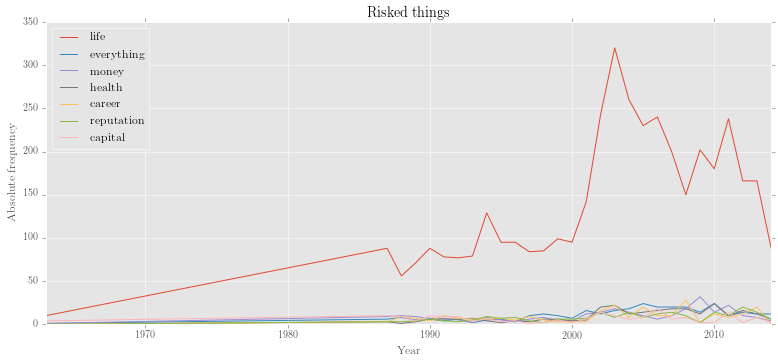

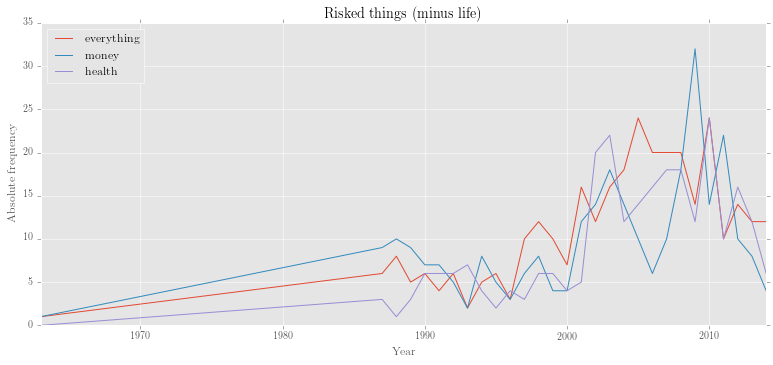

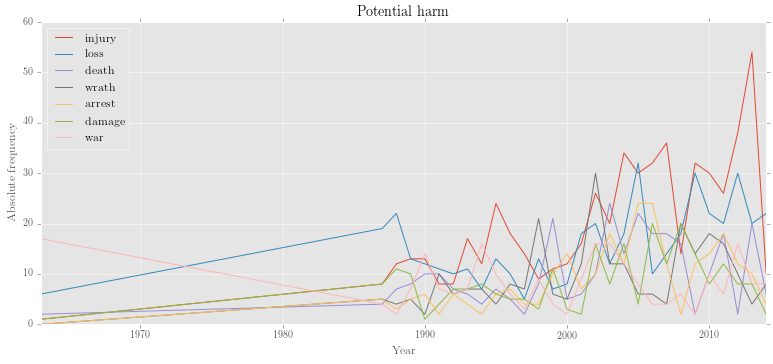

In [495]:
riskobject_regex = (r'(?i)^\b(life|everything|money|career|health|reputation|capital|future|'
    r'job|safety|possibility|anything|return|neck|nothing|lot)$\b')
riskedthings = editor(risk_objects.results, skip_entries = riskobject_regex)
potentialharm = editor(risk_objects.results, just_entries = riskobject_regex)
plotter('Risked things', potentialharm.results, num_to_plot = 7)
# a method for quickly removing entries from the plot:
plotter('Risked things (minus life)', potentialharm.results.drop('life', axis = 1), num_to_plot = 3)
plotter('Potential harm', riskedthings.results, num_to_plot = 7)

It's interesting how powerful people risk losing and alienating electorates, fanbases or contracts, while less powerful people risk their jobs and safety, or their life or neck.

### Risk as modifier

Risk words can serve as modifiers in a number of ways. We divided risk as modifier into five main types.

| Modifier type | Example  |
|---|---|
| Adjectival modifiers of participants  |  *the riskiest decision* | 
| Pre-head nominal modifiers of participants  |  *risk management* | 
|  Post-head nominal modifiers of participants |  *the money to risk* | 
| Adverbial modifiers of processes  |  *it riskily moved* | 
| As head of NP that is head of a cirumstance  | *she was at risk*  | 

In [24]:
query = ([u'Adjectival modifier', r'/NN.?/ >># (NP < (/JJ.?/ < /(?i).?\brisk.?/))'],
    [u'Pre-head nominal modifier', r'/NN.?/ < /(?i).?\brisk.?/ $ (/NN.?/ >># NP !> CC)'], 
    [u'Post-head modifier', r'/NN.?/ >># (NP < (PP < (NP <<# /(?i).?\brisk.?/)))'], 
    [u'Adverbial modifier', r'RB < /(?i).?\brisk.?/'],
    [u'Circumstance head', r'/NN.?/ < /(?i).?\brisk.?/ >># (NP > (PP > (VP > /\b(S|SBAR|ROOT)\b/)))'])
#modifiers = multiquery(annual_trees, query)

Here are a few examples of each type:

In [28]:
for name, q in query:
    print '\n%s:' % name
    l = conc('data/nyt/years/2012', q, n = 5, random = True)


Adjectival modifier:

15:12:58: Getting concordances for data/nyt/years/2012 ... 
          Query: /NN.?/ >># (NP < (/JJ.?/ < /(?i).?\brisk.?/))

0    roped borrowers into risky , high-cost        loans   they could not understand or afford     
1  back to 2008 , when Wall Street 's risky   activities   nearly toppled the financial system and 
2  risk managers need to shed risk-weighted       assets   , and that makes these types of         
3   extensive investigations about low-risk    employees   like themselves who did not have        
4  encouraging localities to treat low-risk    offenders   in community-based programs             

Pre-head nominal modifier:

15:15:13: Getting concordances for data/nyt/years/2012 ... 
          Query: /NN.?/ < /(?i).?\brisk.?/ $ (/NN.?/ >># NP !> CC)

0    to have firsthand knowledge about the   risk   factors among offenders , which gives   
1     a higher body mass index was a major   risk   factor for acne , `` especially         
2         


***Processing results***

Skipping 1 subcorpora:
    1963

***Done!***



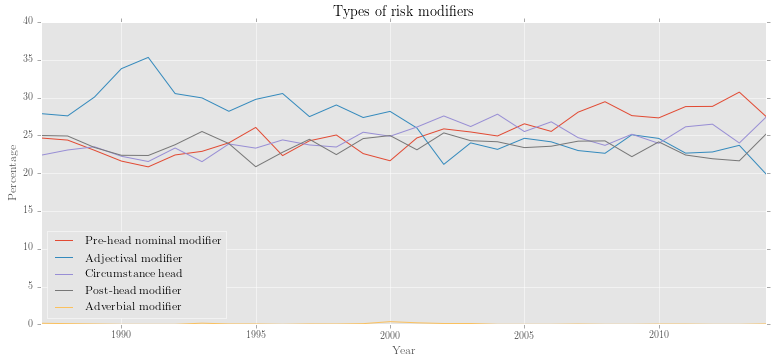

In [484]:
plotter('Types of risk modifiers', editor(modifiers.results, '%', modifiers.totals, skip_subcorpora = [1963]).results)

This is very interesting: the most common form in 1987 has become the least common in 2014!

We can also pull out words modified by adjectival risk:

In [421]:
# Participants modified by risk word
query = r'/NN.?/ >># (NP < (/JJ.?/ < /(?i).?\brisk.?/) ( > VP | $ VP))'
mod_by_adj_risk = interrogator(annual_trees, 'words', query, 
    lemmatise = True, titlefilter = False)

 20:47:48: Finished! 897 unique results, 8705 total.


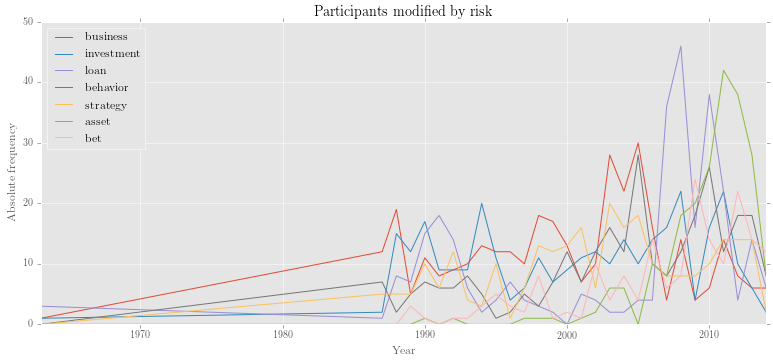

In [422]:
plotter('Participants modified by risk', mod_by_adj_risk.results, 
    num_to_plot = 7)

We looked at the most common adjectival risks:

In [423]:
query = r'/JJ.?/ < /(?i).?\brisk.?/'
adjrisks = interrogator(annual_trees, 'words', query, 
    lemmatise = False)

 20:57:26: Finished! 355 unique results, 45604 total.


In [424]:
arisk = editor(adjrisks.results, '%', allwords.totals) 


***Processing results***

***Done!***



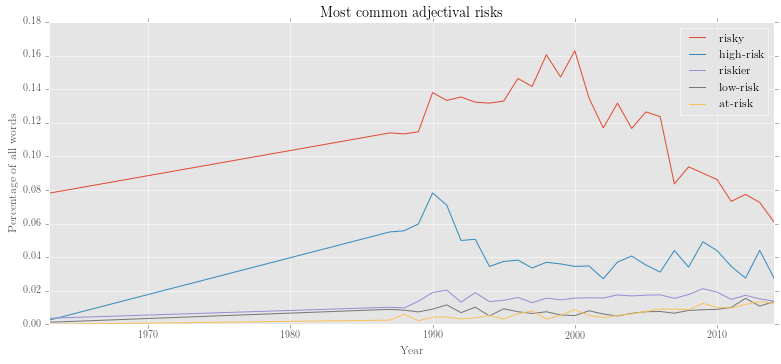

In [425]:
# remember that we can still plot using all words/all risk words 
plotter('Most common adjectival risks', arisk.results, y_label = 'Percentage of all words', num_to_plot = 5)

Given the increasing frequency of at-risk constructions, we then looked at what it is that this modifier typically modifies.

In [ ]:
# At-risk thing
query = r'/NN.?/ >># (NP < (/JJ.?/ < /(?i).?\bat-risk/) ( > VP | $ VP))'
at_risk_things = interrogator(annual_trees, 'words', query, lemmatise = True)

In [536]:
x = editor(at_risk_things.results, '%', at_risk_things.totals, skip_subcorpora = [1963])


***Processing results***

Skipping 1 subcorpora:
    1963

***Done!***



In [626]:
a_r_t = editor(at_risk_things.results, '%', at_risk_things.totals, skip_subcorpora = [1963], just_totals = True)


***Processing results***

Skipping 1 subcorpora:
    1963


***Done!***



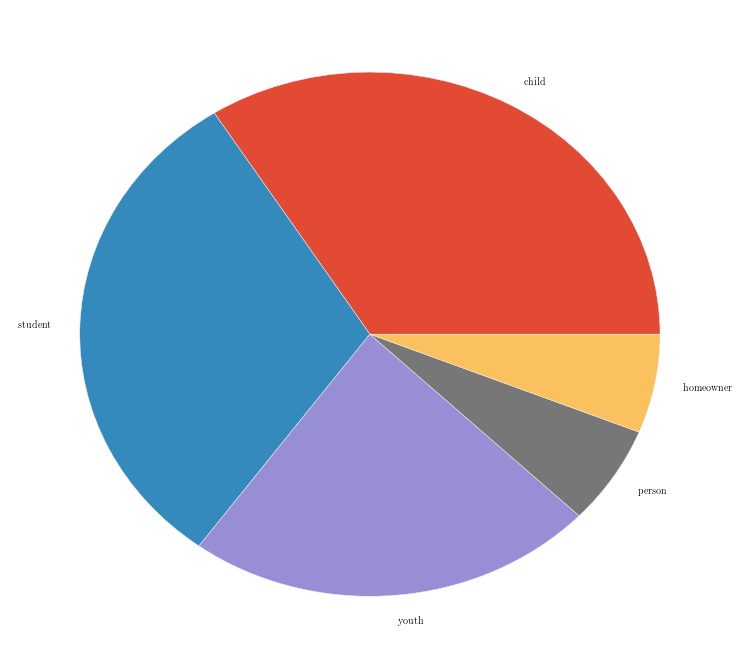

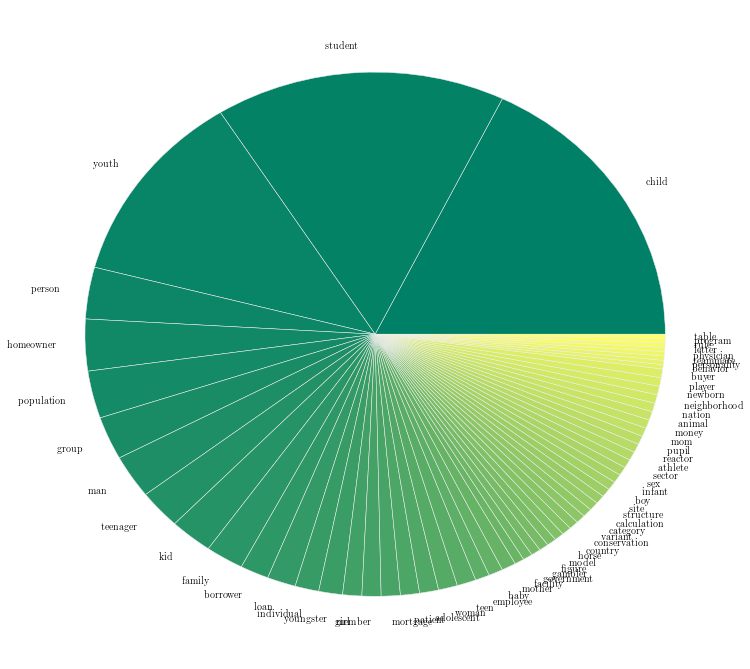

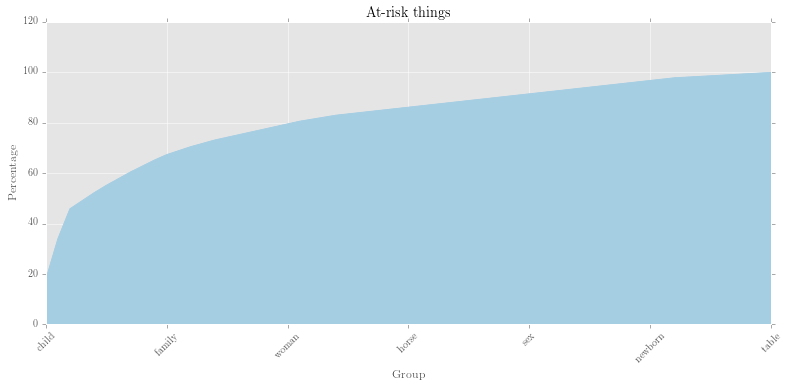

In [631]:
plotter('At-risk things', a_r_t.results, kind = 'pie', num_to_plot = 5)
plotter('At-risk things', a_r_t.results, kind = 'pie', num_to_plot = 'all', colours = 'summer')
plotter('At-risk things', a_r_t.results, kind = 'area', num_to_plot = 'all', cumulative = True)

The query below finds both *thing at risk* and *at-risk thing*.

In [487]:
# at-risk person / person at risk combined
query = r'/NN.?/ ( >># (NP < (PP <<# /(?i)at/ << (NP <<# /(?i)\brisk.?/))) | ( >># (NP < (/JJ.?/ < /(?i)at-risk.?/))))'
n_atrisk_n = interrogator(annual_trees, 'words', query, 
    lemmatise = False, titlefilter = False)

 22:03:38: Finished! 1225 unique results, 7044 total.


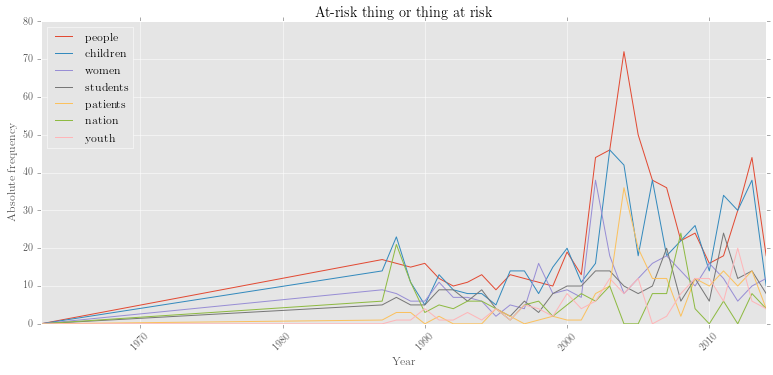

In [628]:
plotter('At-risk thing or thing at risk', n_atrisk_n.results, legend = 'upper left')

Vulnerable human populations are the main theme of this category: indeed, it's difficult to imagine *at-risk corporations* or *at-risk leaders*.

### Proper nouns and risk sentences

We searched to find the most common proper noun strings.

`interrogator()`'s `titlefilter` option removes common titles, first names and determiners to make for more accurate counts. It is useful when the results being returned are groups/phrases, rather than single words.

In [489]:
# Most common proper noun phrases
query = r'NP <# NNP >> (ROOT << /(?i).?\brisk.?\b/)'
propernouns = interrogator(annual_trees, 'words', query, 
    titlefilter = True)

 22:15:06: Finished! 68120 unique results, 280355 total.


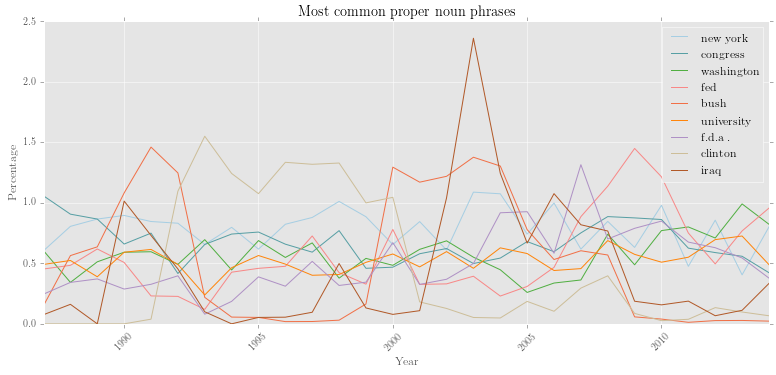

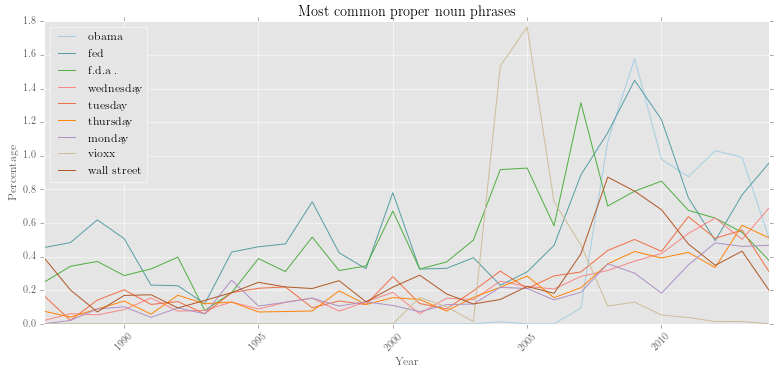

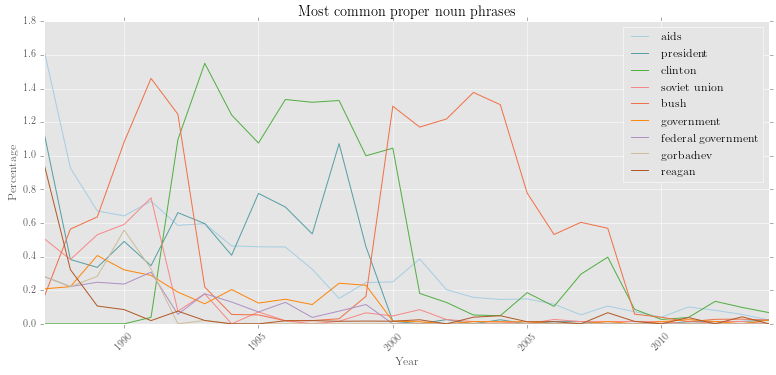

In [630]:
for s in ['total', 'increase', 'decrease']:
    r = editor(propernouns.results, '%', propernouns.totals, skip_subcorpora=[1963], sort_by = s, print_info = False)
    plotter('Most common proper noun phrases', r.results, num_to_plot = 9)

In [491]:
quickview(propernouns, n = 200)

  0: new york (n=2215)
  1: congress (n=1869)
  2: washington (n=1639)
  3: iraq (n=1583)
  4: university (n=1519)
  5: bush (n=1517)
  6: china (n=1207)
  7: fed (n=1173)
  8: europe (n=1090)
  9: obama (n=1032)
 10: america (n=970)
 11: f.d.a . (n=956)
 12: wall street (n=926)
 13: clinton (n=887)
 14: israel (n=873)
 15: tuesday (n=839)
 16: vioxx (n=805)
 17: russia (n=765)
 18: wednesday (n=761)
 19: food and drug administration (n=724)
 20: thursday (n=695)
 21: merck (n=683)
 22: white house (n=683)
 23: aids (n=674)
 24: japan (n=663)
 25: friday (n=643)
 26: california (n=608)
 27: london (n=608)
 28: monday (n=602)
 29: iran (n=577)
 30: federal reserve (n=562)
 31: medicine (n=536)
 32: greenspan (n=516)
 33: manhattan (n=515)
 34: afghanistan (n=502)
 35: bank (n=487)
 36: new york city (n=483)
 37: president (n=474)
 38: u.s . (n=470)
 39: department (n=466)
 40: britain (n=452)
 41: germany (n=394)
 42: democrat (n=394)
 43: center (n=388)
 44: senate (n=372)
 45: france 

Notice that there are a few entries here that refer to the same group. (*f.d.a.* and *food and drug administration*, for example). We can use `editor()` to fix these.

In [546]:
to_merge = [("f.d.a .", "food and drug administration"),
    ("fed", "federal reserve"),
    ("s.e.c .", "securities and exchange commission"),
    ("disease control", "disease control and prevention"),
    ("goldman sachs", "goldman"),
    ("e.p.a .", "envi,ronmental protection agency"),
    ("calif .", "california"),
    ("i.m.f .", "international monetary fund")]

safe_copy = propernouns.results.copy() # just in case
for short, long in to_merge:
    propernouns = editor(propernouns.results, merge_entries = [short, long], newname = short)
propernouns = editor(propernouns.results, sort_by = 'total')
propernouns.results

new york  congress  fed  f.d.a .  washington ...  # 1988 seen  kyl  kurt sampson  kurtis  sa
1963   12         7         0    0        4        ...  0            0    0             0       0 
1987   32        56        24   13       32        ...  1            0    0             0       0 
1988   40        45        24   17       17        ...  0            0    0             0       0 
1989   49        49        35   21       29        ...  0            0    1             0       0 
1990   53        39        30   17       35        ...  0            0    0             0       1 
1991   44        39        12   17       31        ...  0            0    0             1       0 
1992   44        22        12   21       26        ...  0            0    0             0       0 
1993   33        33         6    4       35        ...  0            0    0             0       0 
...        ...       ...  ...      ...         ... ...          ...  ...           ...     ...  ..
2007   92       112       132  196       54        ...  0            0    0             0       0 
2008  128       134       172  106      112        ...  0            0    0             0       0 
2009   88       122       202  110       68        ...  0            0    0             0       0 
2010  150       132       186  130      118        ...  0            0    0             0       0 
2011   76       100       120  108      128        ...  0            0    0             0       0 
2012  128        88        74   94      106        ...  0            0    0             0       0 
2013   58        80       110   78      142        ...  0            0    0             0       0 
2014   72        38        86   34       74        ...  0            0    0             0       0 

[29 rows x 68113 columns]

Now that we've merged some common results, we can build some basic thematic categories. Let's make a list of lists:

In [551]:
theme_list = [['People', r'(?i)^\b(bush|clinton|obama|greenspan|gore|johnson|mccain|romney|kennedy|giuliani|reagan)$\b'],
    ['Nations', r'(?i)^\b(iraq|china|america|israel|russia|japan|frace|germany|iran|britain|u\.s\.|afghanistan|australia|canada|spain|mexico|pakistan|soviet union|india)$\b'],
    ['Geopolitical entities', r'(?i)^\b(middle east|asia|europe|america|soviet union|european union)$\b'],
    ['US places', r'(?i)^\b(new york|washington|wall street|california|manhattan|new york city|new jersey|north korea|italy|greece|bosniaboston|los angeles|broadway|texas)$\b'],
    ['Companies', r'(?i)^\b(merck|avandia|citigroup|pfizer|bayer|enron|apple|microsoft|empire)$\b'],
    ['Organisations', r'(?i)^\b(white house|congress|federal reserve|nasa|pentagon|f\.d\.a \.|c\.i\.a \.|f\.b\.i \.|e\.p\.a \.)$'],
    ['Medical', r'(?i)^\b(vioxx|aids|aid|celebrex|f\.d\.a \.|pfizer|bayer|merck|avandia)$']]

We can add each result to its entry in `theme_list`, and give the `totals` a name:

In [552]:
# add data to our sublists
for entry in theme_list:
    entry.append(editor(propernouns.results, '%', propernouns.totals, 
                  just_entries = entry[1], print_info = False))
    # rename the newly created data
    entry[2].totals.name = entry[0]

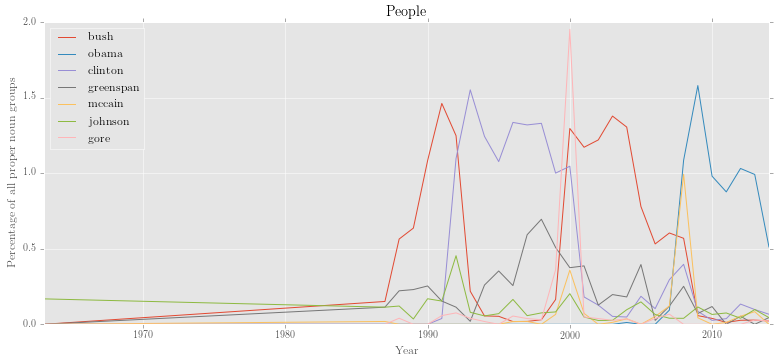

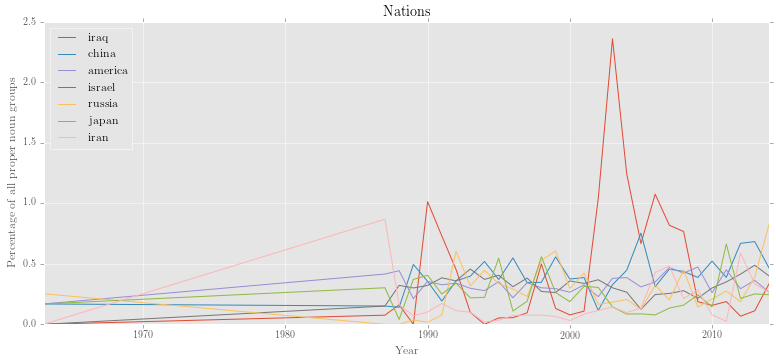

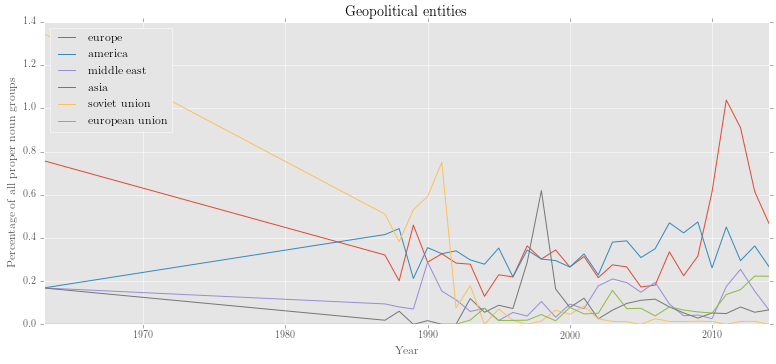

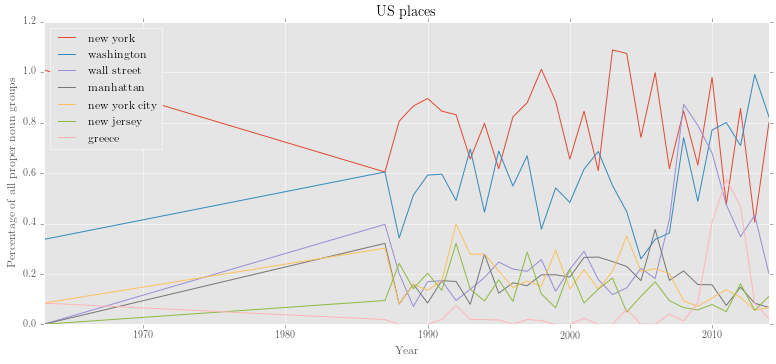

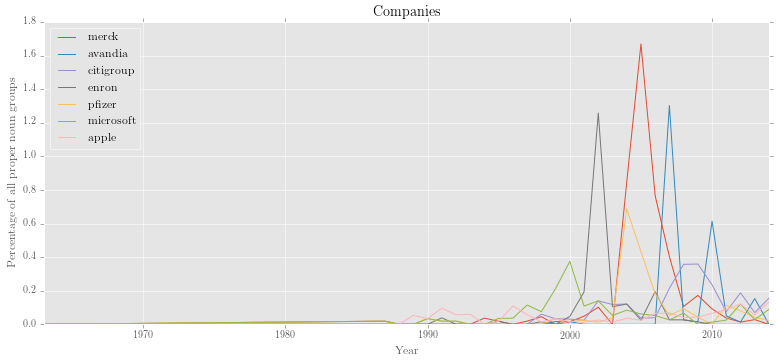

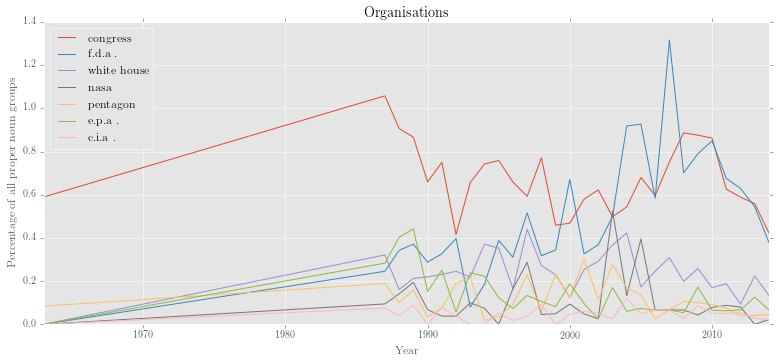

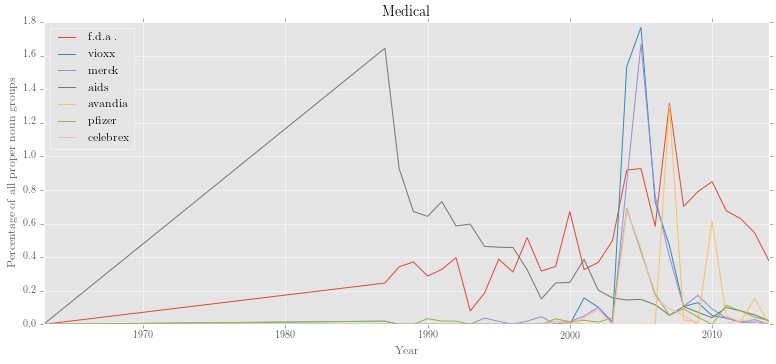

In [553]:
# plot some results
ystring = 'Percentage of all proper noun groups'
for name, query, data in theme_list:
    plotter(name, data.results, y_label = ystring, legend = 'upper left')

Let's compare these topics in the same chart, using Pandas to join everything together:

In [554]:
import pandas
# get the totals from each theme and put them together
them_comp = pandas.concat([data.totals for name, query, data in theme_list], axis=1)
them_comp = editor(them_comp, sort_by = 'total')
quickview(them_comp)


***Processing results***


***Done!***

  0: Nations (n=94)
  1: US places (n=75)
  2: People (n=55)
  3: Organisations (n=53)
  4: Medical (n=39)
  5: Geopolitical entities (n=32)
  6: Companies (n=17)


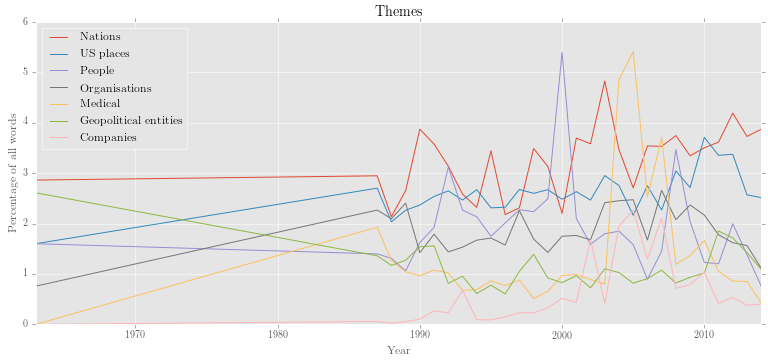

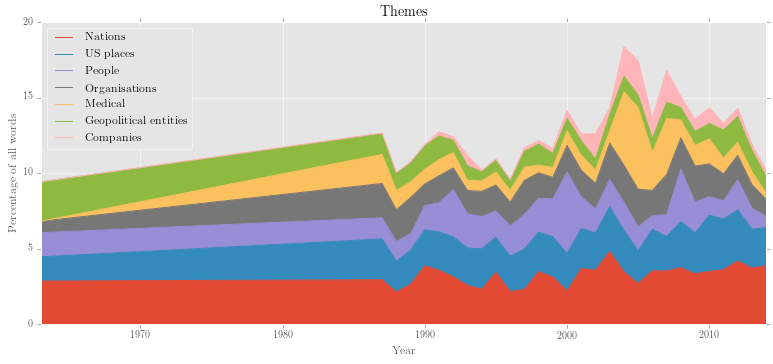

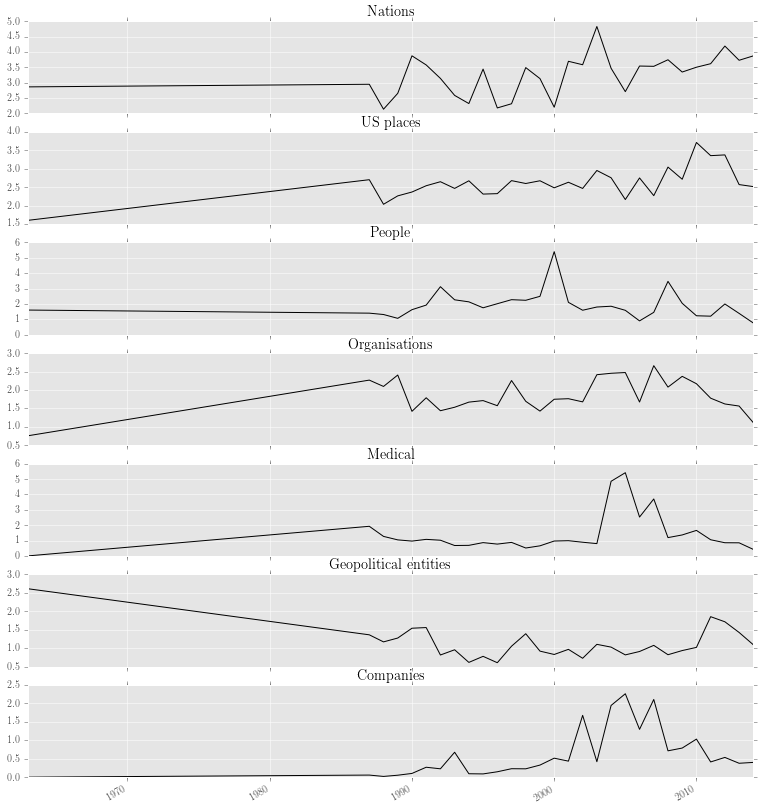

In [555]:
plotter('Themes', them_comp.results, y_label = 'Percentage of all words')
plotter('Themes', them_comp.results, kind = 'area', stacked = True, y_label = 'Percentage of all words')
plotter('Themes', them_comp.results, subplots = True, y_label = 'Percentage of all words')

These charts reveal some interesting patterns.

* We can clearly see presidencies and rival candidates come and go
* Similarly, the wars in Iraq and Afghanistan are easy to spot
* Naturally, the Soviet Union is a very frequent topic in 1963. It rises in frequency until its collapse. More recently, Russia can be seen as more frequently co-occurring with risk words.
* The Eurozone crisis is visible
* From the Organisations and Things, we can see the appearance of Merck and Vioxx in 2004, as well as Empire...


***Processing results***

Skipping 1 subcorpora:
    1963

Keeping 2 entries:
    vioxx
    merck


***Done!***



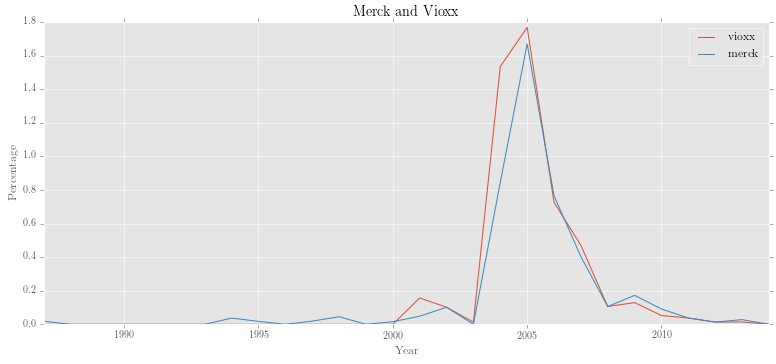

In [558]:
vioxx = editor(propernouns.results, '%', propernouns.totals, just_entries = r'(?i)^\b(vioxx|merck)\b$', skip_subcorpora=1963)
plotter('Merck and Vioxx', vioxx.results)

Vioxx was removed from shelves following the discovery that it increased the risk of heart attack. It's interesting how even though terrorism and war may come to mind when thinking of *risk* in the past 15 years, this health topic is easily more prominent in the data.

## Discussion

OK, that's enough interrogating and plotting for now. Future documents will demonstrate how we can use Stanford Dependencies, instead of parse trees, to understand change in the risk semantic.

### Limitations

A key challenge accounting for the diverse ways in which a semantic meaning can be made in lexis and grammar. If we are interested in how often *money* is the risked thing, we have to design searches that find: 

     She risked her money
     She risked losing her money
     Money was risked
     It was risked money
     The risk of money loss was there
     She took her money from her purse and risked it.

Though we can design queries to match any of these, it is very difficult to automate this process for every possible 'risked thing'. It's also very hard to know when we have finally developed a query that matches everything we want.

An added issue is how to treat things like:

     She didn't risk her money
     She risked no money
     She could risk money

Here, the semantic meanings are very different (the risking of money did not occur), but each would match the queries we designed for the above.

Should these results be counted or excluded? Why?

### References

<a id="eggins"></a>
Eggins, S. (2004). Introduction to systemic functional linguistics. Continuum International Publishing Group.

<a id="firth"></a>
Firth, J. (1957).  *A Synopsis of Linguistic Theory 1930-1955*. In: Studies in Linguistic Analysis, Philological Society, Oxford; reprinted in Palmer, F. (ed.) 1968 Selected Papers of J. R. Firth, Longman, Harlow.

<a id="hallmat"></a>
Halliday, M., & Matthiessen, C. (2004). An Introduction to Functional Grammar. Routledge.